In [1]:
# load a coffea file
from coffea.util import load
import os
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib
from scipy.stats import pearsonr
# from distance_correlation import distance_correlation
plt.style.use(hep.style.CMS)
import torch

matplotlib.rcParams["figure.dpi"] = 300

/work/mmalucch/micromamba/envs/ML_pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# REGION='control_region'
# REGION='signal_region'
REGION='baseline'
NUM_EVENTS=-1


In [3]:
# from https://gitlab.cern.ch/cms-analysis/mlg/mlg-23-003/abcdiscotec/-/blob/master/abcdiscotec/_utilities.py?ref_type=heads
def distance_correlation(
        var_1:torch.tensor,
        var_2:torch.tensor,
        normedweight:torch.tensor,
        power=1,
        )->torch.tensor:
    """
    Compute the distance correlation function
    between two variables.

    Args:
        var_1 (torch.tensor): The first variable.
        var_2 (torch.tensor): The second variable.
        normedweight (torch.tensor): The weight matrix.
        power (int): The power of the distance correlation.

    Returns:
        torch.tensor: The distance correlation between the two variables.
    """
    
    # Normalize the weights
    normedweight = normedweight/torch.sum(normedweight)*len(var_1)
    
    xx = var_1.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))
    yy = var_1.repeat(len(var_1),1).view(len(var_1),len(var_1))
    amat = (xx-yy).abs()

    xx = var_2.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))
    yy = var_2.repeat(len(var_2),1).view(len(var_2),len(var_2))
    bmat = (xx-yy).abs()

    amatavg = torch.mean(amat*normedweight,dim=1)
    Amat=amat-amatavg.repeat(len(var_1),1).view(len(var_1),len(var_1))\
        -amatavg.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))\
        +torch.mean(amatavg*normedweight)

    bmatavg = torch.mean(bmat*normedweight,dim=1)
    Bmat=bmat-bmatavg.repeat(len(var_2),1).view(len(var_2),len(var_2))\
        -bmatavg.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))\
        +torch.mean(bmatavg*normedweight)

    ABavg = torch.mean(Amat*Bmat*normedweight,dim=1)
    AAavg = torch.mean(Amat*Amat*normedweight,dim=1)
    BBavg = torch.mean(Bmat*Bmat*normedweight,dim=1)

    if(power==1):
        dCorr=(torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight)))
    elif(power==2):
        dCorr=(torch.mean(ABavg*normedweight))**2/(torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))
    else:
        dCorr=((torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))))**power
    
    return dCorr


In [4]:

def get_cols_from_file(input, region=REGION):
    o = load(f"{input}")
    sample=list(o["columns"].keys())[0]
    dataset=list(o["columns"][sample].keys())[0]
    categories = list(o["columns"][sample][dataset].keys())
    print(f"sample: {sample}, dataset: {dataset} categories: {categories}")
    col=o["columns"][sample][dataset][region]

    for k in col.keys():
        # print(k)
        col[k]=col[k].value
        
    return col

In [5]:
def correlation_plot(var1, var2, title, bins=(np.linspace(0, 1, 100), np.linspace(0, 8, 100))):
    var1 = ak.to_numpy(ak.flatten(var1, axis=None))
    var2 = ak.to_numpy(ak.flatten(var2, axis=None))
    # compute the correlation between the var1 of the 3rd jet and the var2
    plt.figure(figsize=(12, 12))
    # put the log in the color scale
    plt.hist2d(
        var1,
        var2,
        bins=bins,
        cmap="viridis",
        cmin=1,
        norm=matplotlib.colors.LogNorm(),
        density=False,
        weights=np.ones_like(var2),
    )
    plt.colorbar(label="Counts")

    # compute the correlation coefficient
    corr, _ = pearsonr(var1, var2)

    var1 = torch.tensor(var1)
    var2 = torch.tensor(var2)
    normedweight = torch.ones_like(var1)  # Assuming uniform weights for simplicity
    # disco = distance_correlation(var1, var2, normedweight, power=1)
    disco = 0
    print(f"Pearson correlation coefficient (spanet ): {corr:.6f}")

    plt.title(
        f"{title} \nPearson correlation coefficient: {corr:.6f} \nDistance correlation: {disco:.6f}"
    )

    plt.show()

    # plot the scatter plot
    # plt.scatter(var1, var2, s=1, alpha=0.5, color='red')
    # plt.title(f"{title} \nPearson correlation coefficient: {corr:.2f}")
    # plt.show()

In [6]:
def get_plot_cols(col):
    btag=col["JetGood_btagPNetB"]
    btag_unflattened=ak.unflatten(btag, col["JetGood_N"])[:NUM_EVENTS]
    pd=col["events_Arctanh_Delta_pairing_probabilities"][:NUM_EVENTS]
    higgs1_mass=col["HiggsLeading_mass"][:NUM_EVENTS]
    higgs2_mass=col["HiggsSubLeading_mass"][:NUM_EVENTS]
    rhh=np.sqrt(
                    (higgs1_mass - 125) ** 2
                    + (higgs2_mass - 120) ** 2
                )

    return btag_unflattened, pd, rhh

In [7]:
input_btag = "/work/mmalucch/out_hh4b/btag_ratio/out_ggF_ERAG_baseline_category_ptflat/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"
col_btag = get_cols_from_file(input_btag, "baseline")

input_bratio = "/work/mmalucch/out_hh4b/btag_ratio/out_ggF_ERAG_baseline_category_ptflat_bratio/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"
col_btag_ratio = get_cols_from_file(input_bratio, "baseline")

input_btag_mc='/work/mmalucch/out_hh4b/btag_ratio/out_ggF_ERAG_baseline_category_ptflat/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea'
col_btag_mc = get_cols_from_file(input_btag_mc, "baseline")

input_btag_ratio_mc='/work/mmalucch/out_hh4b/btag_ratio/out_ggF_ERAG_baseline_category_ptflat_bratio/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea'
col_btag_ratio_mc = get_cols_from_file(input_btag_ratio_mc, "baseline")

sample: DATA_JetMET_JMENano_G_skimmed, dataset: DATA_JetMET_JMENano_G_2022_postEE_EraG categories: ['baseline']
sample: DATA_JetMET_JMENano_G_skimmed, dataset: DATA_JetMET_JMENano_G_2022_postEE_EraG categories: ['baseline']
sample: GluGlutoHHto4B_spanet_skimmed, dataset: GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE categories: ['baseline']
sample: GluGlutoHHto4B_spanet_skimmed, dataset: GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE categories: ['baseline']


In [8]:
btag_spanet_unflattened, pd_spanet, rhh = get_plot_cols(col_btag)
btag_spanet_ratio_unflattened, pd_spanet_ratio, rhh_ratio = get_plot_cols(col_btag_ratio)
btag_spanet_mc_unflattened, pd_spanet_mc, rhh_mc = get_plot_cols(col_btag_mc)
btag_spanet_ratio_mc_unflattened, pd_spanet_ratio_mc, rhh_ratio_mc = get_plot_cols(col_btag_ratio_mc)


# Rhh vs PD

Pearson correlation coefficient (spanet ): -0.128799


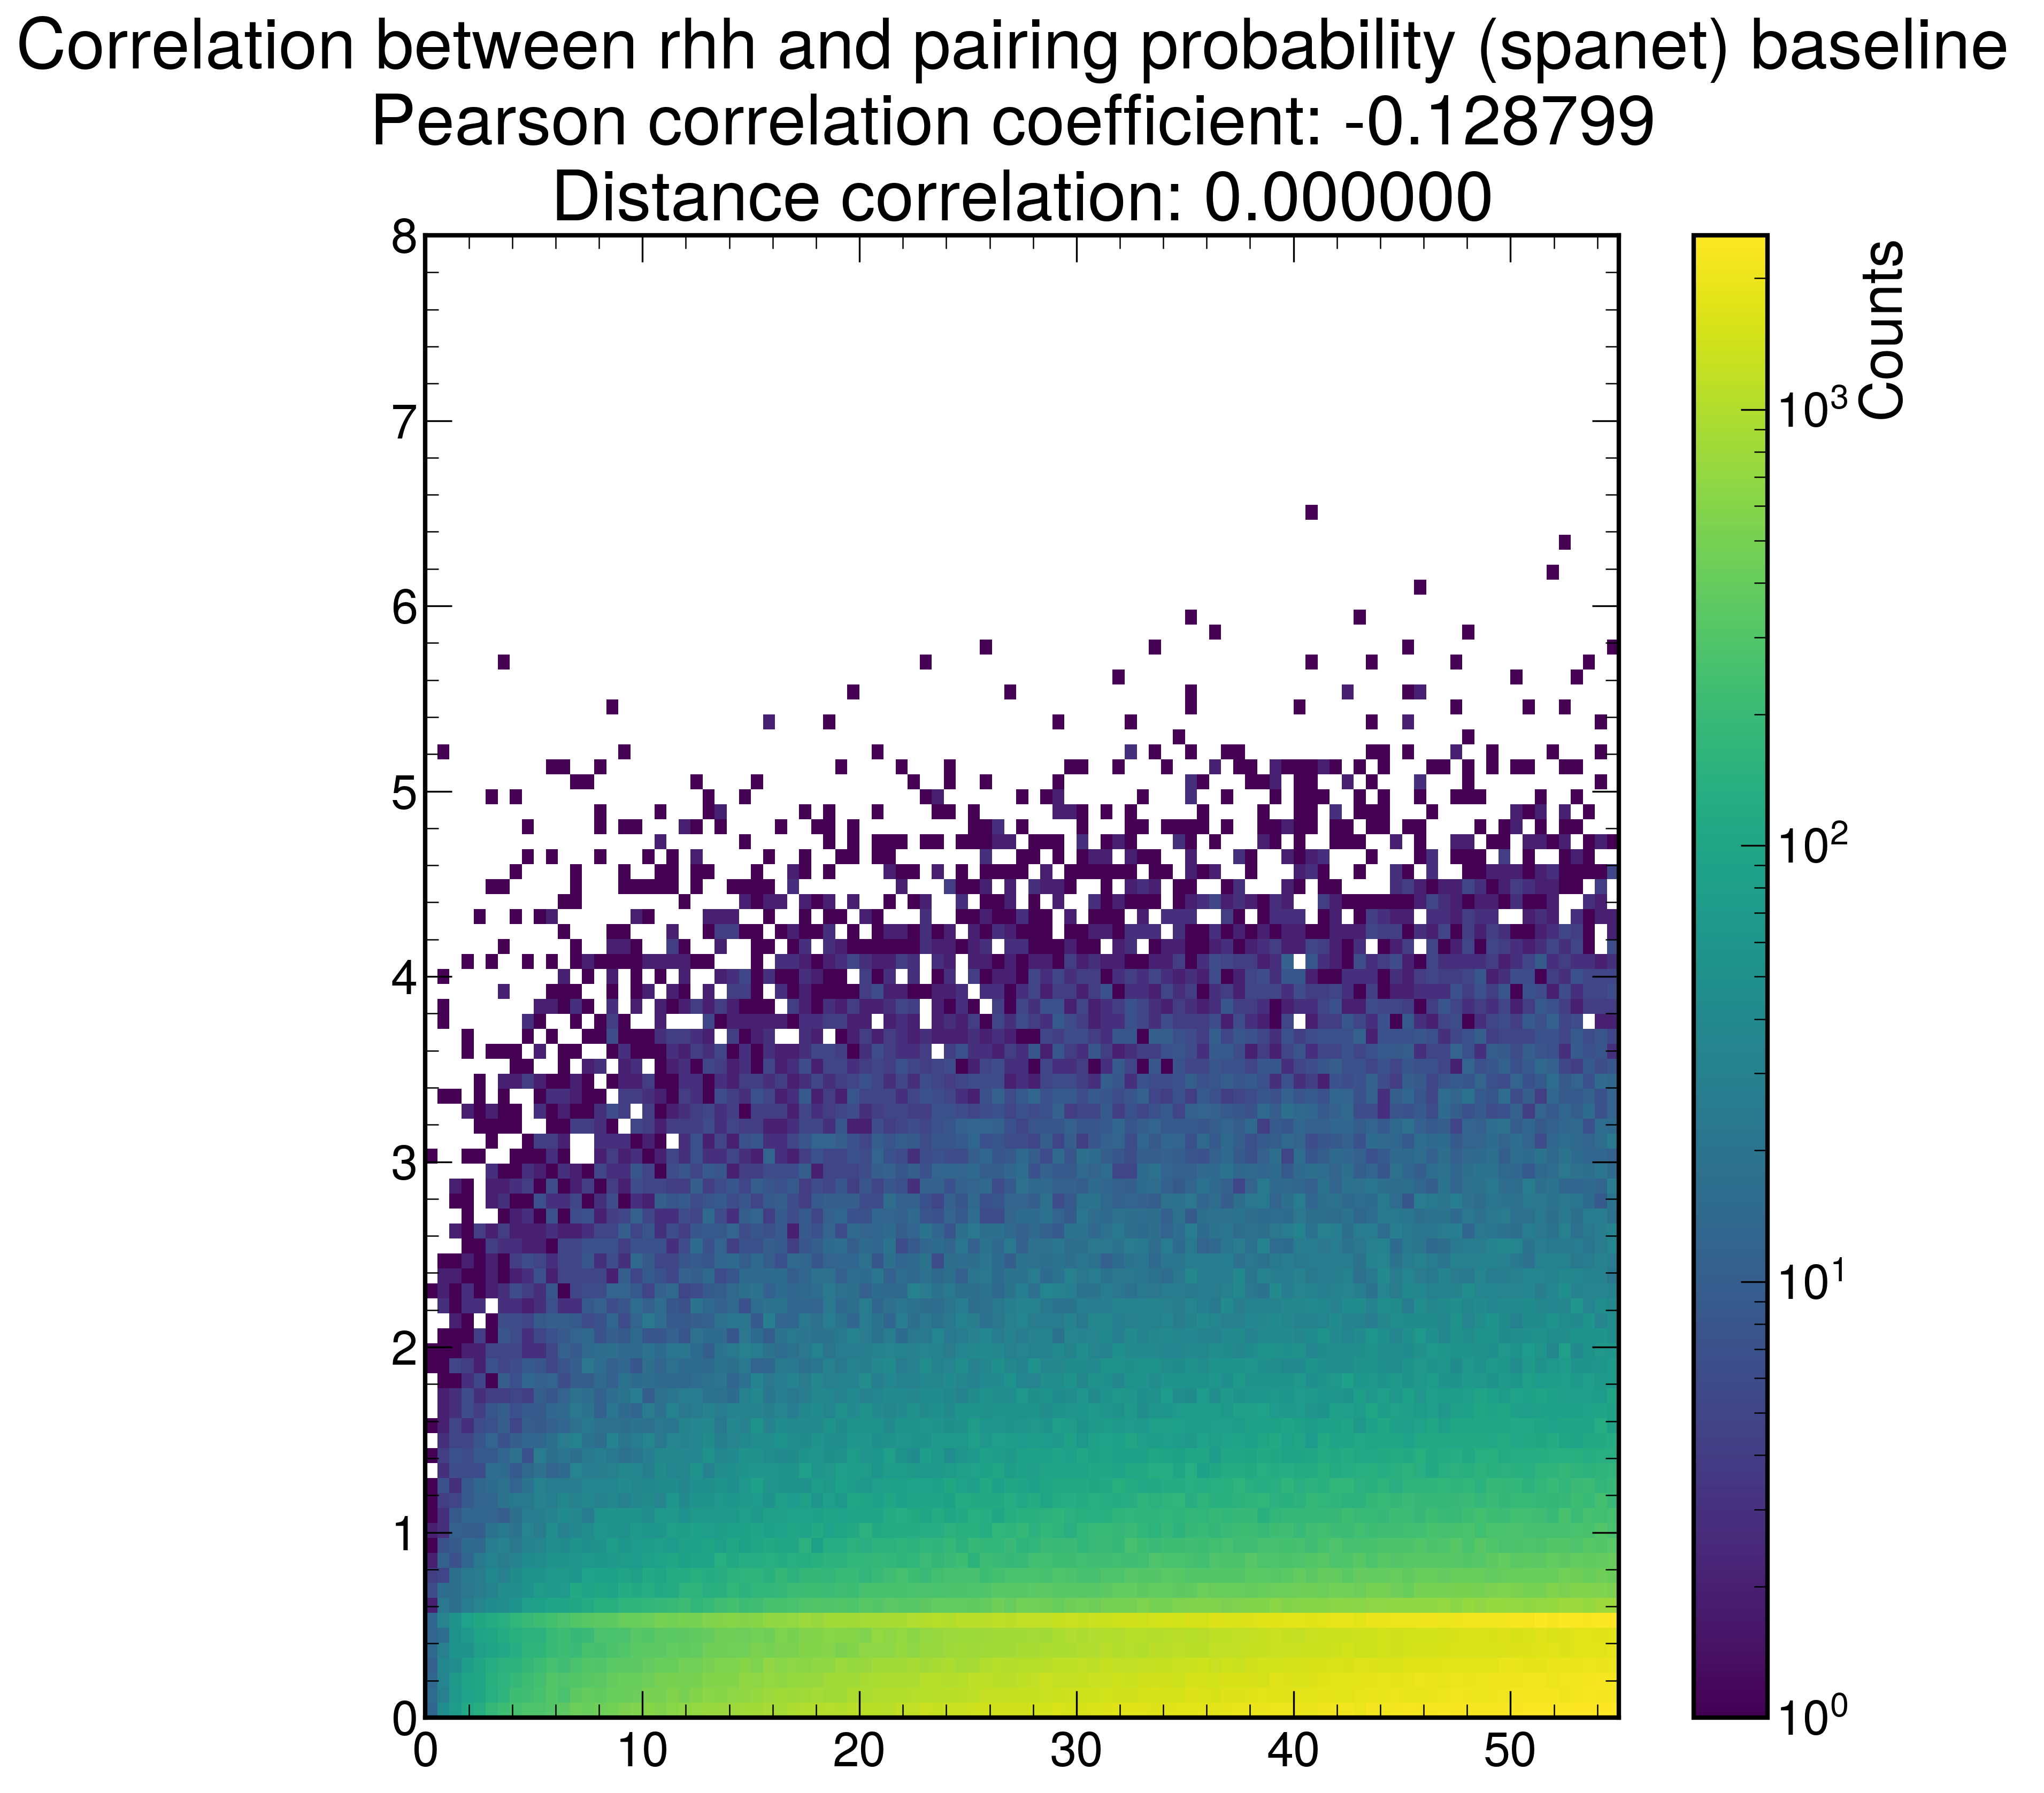

Pearson correlation coefficient (spanet ): -0.179464


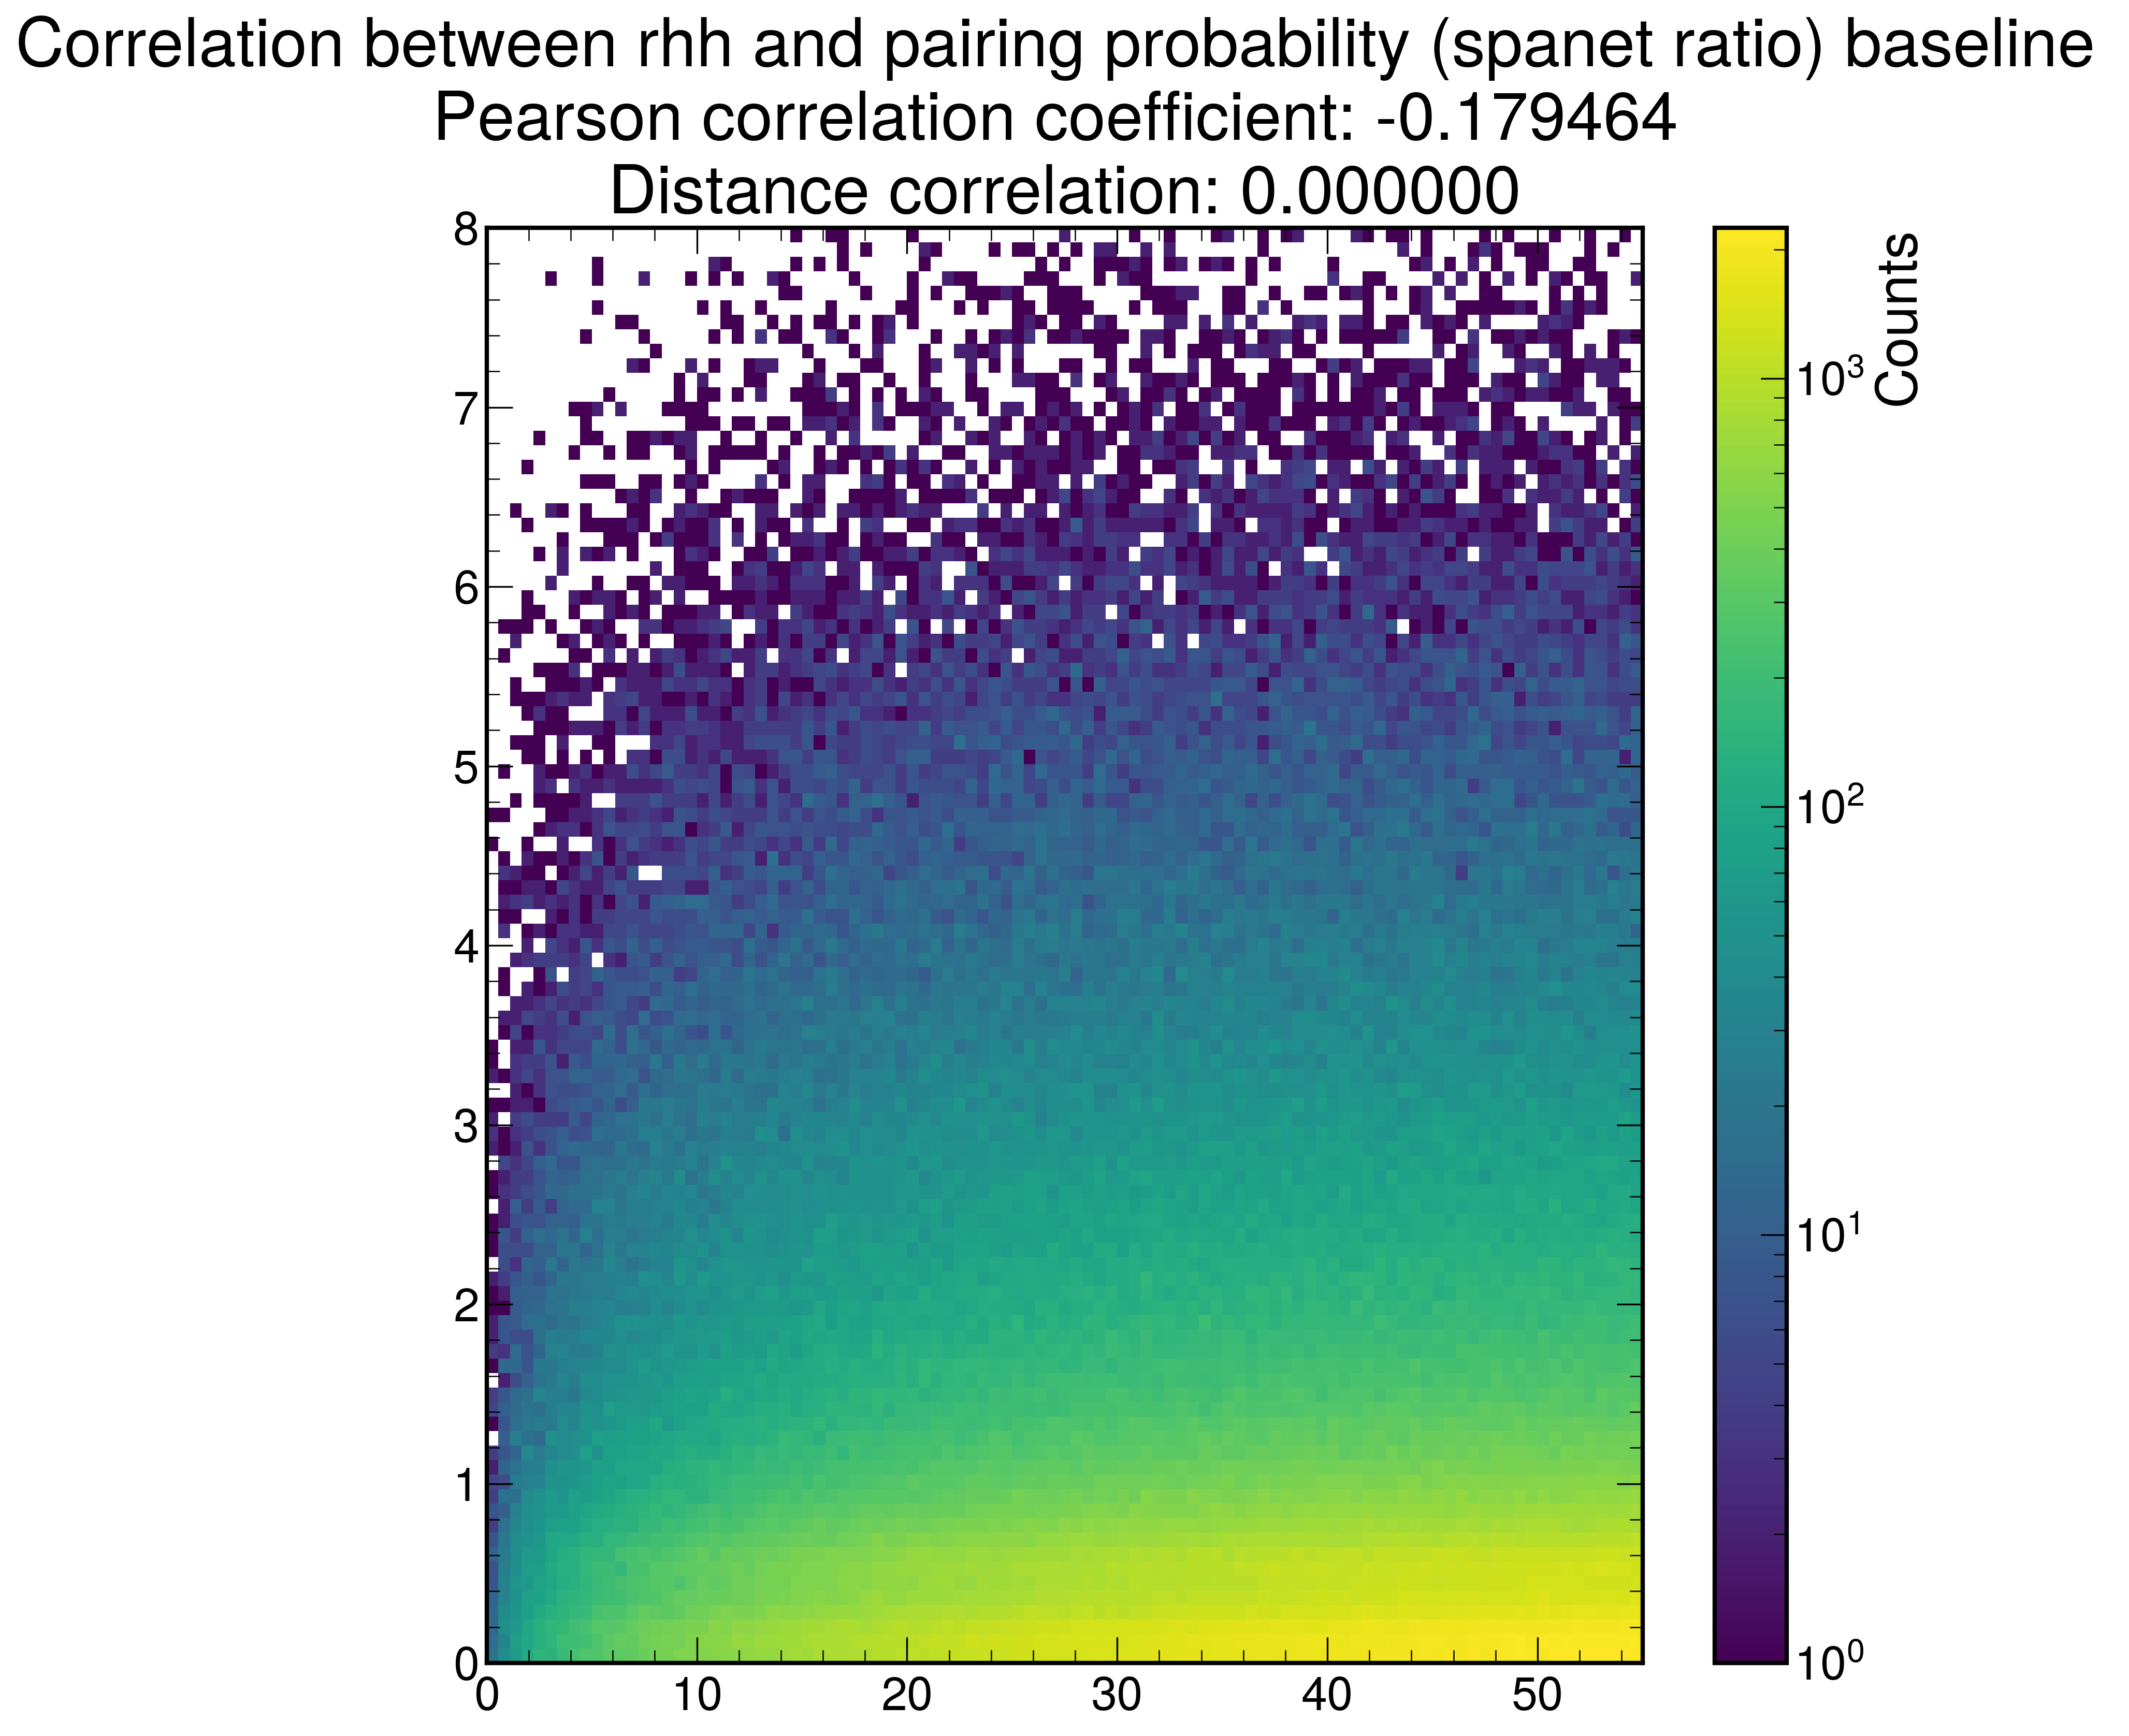

Pearson correlation coefficient (spanet ): -0.340141


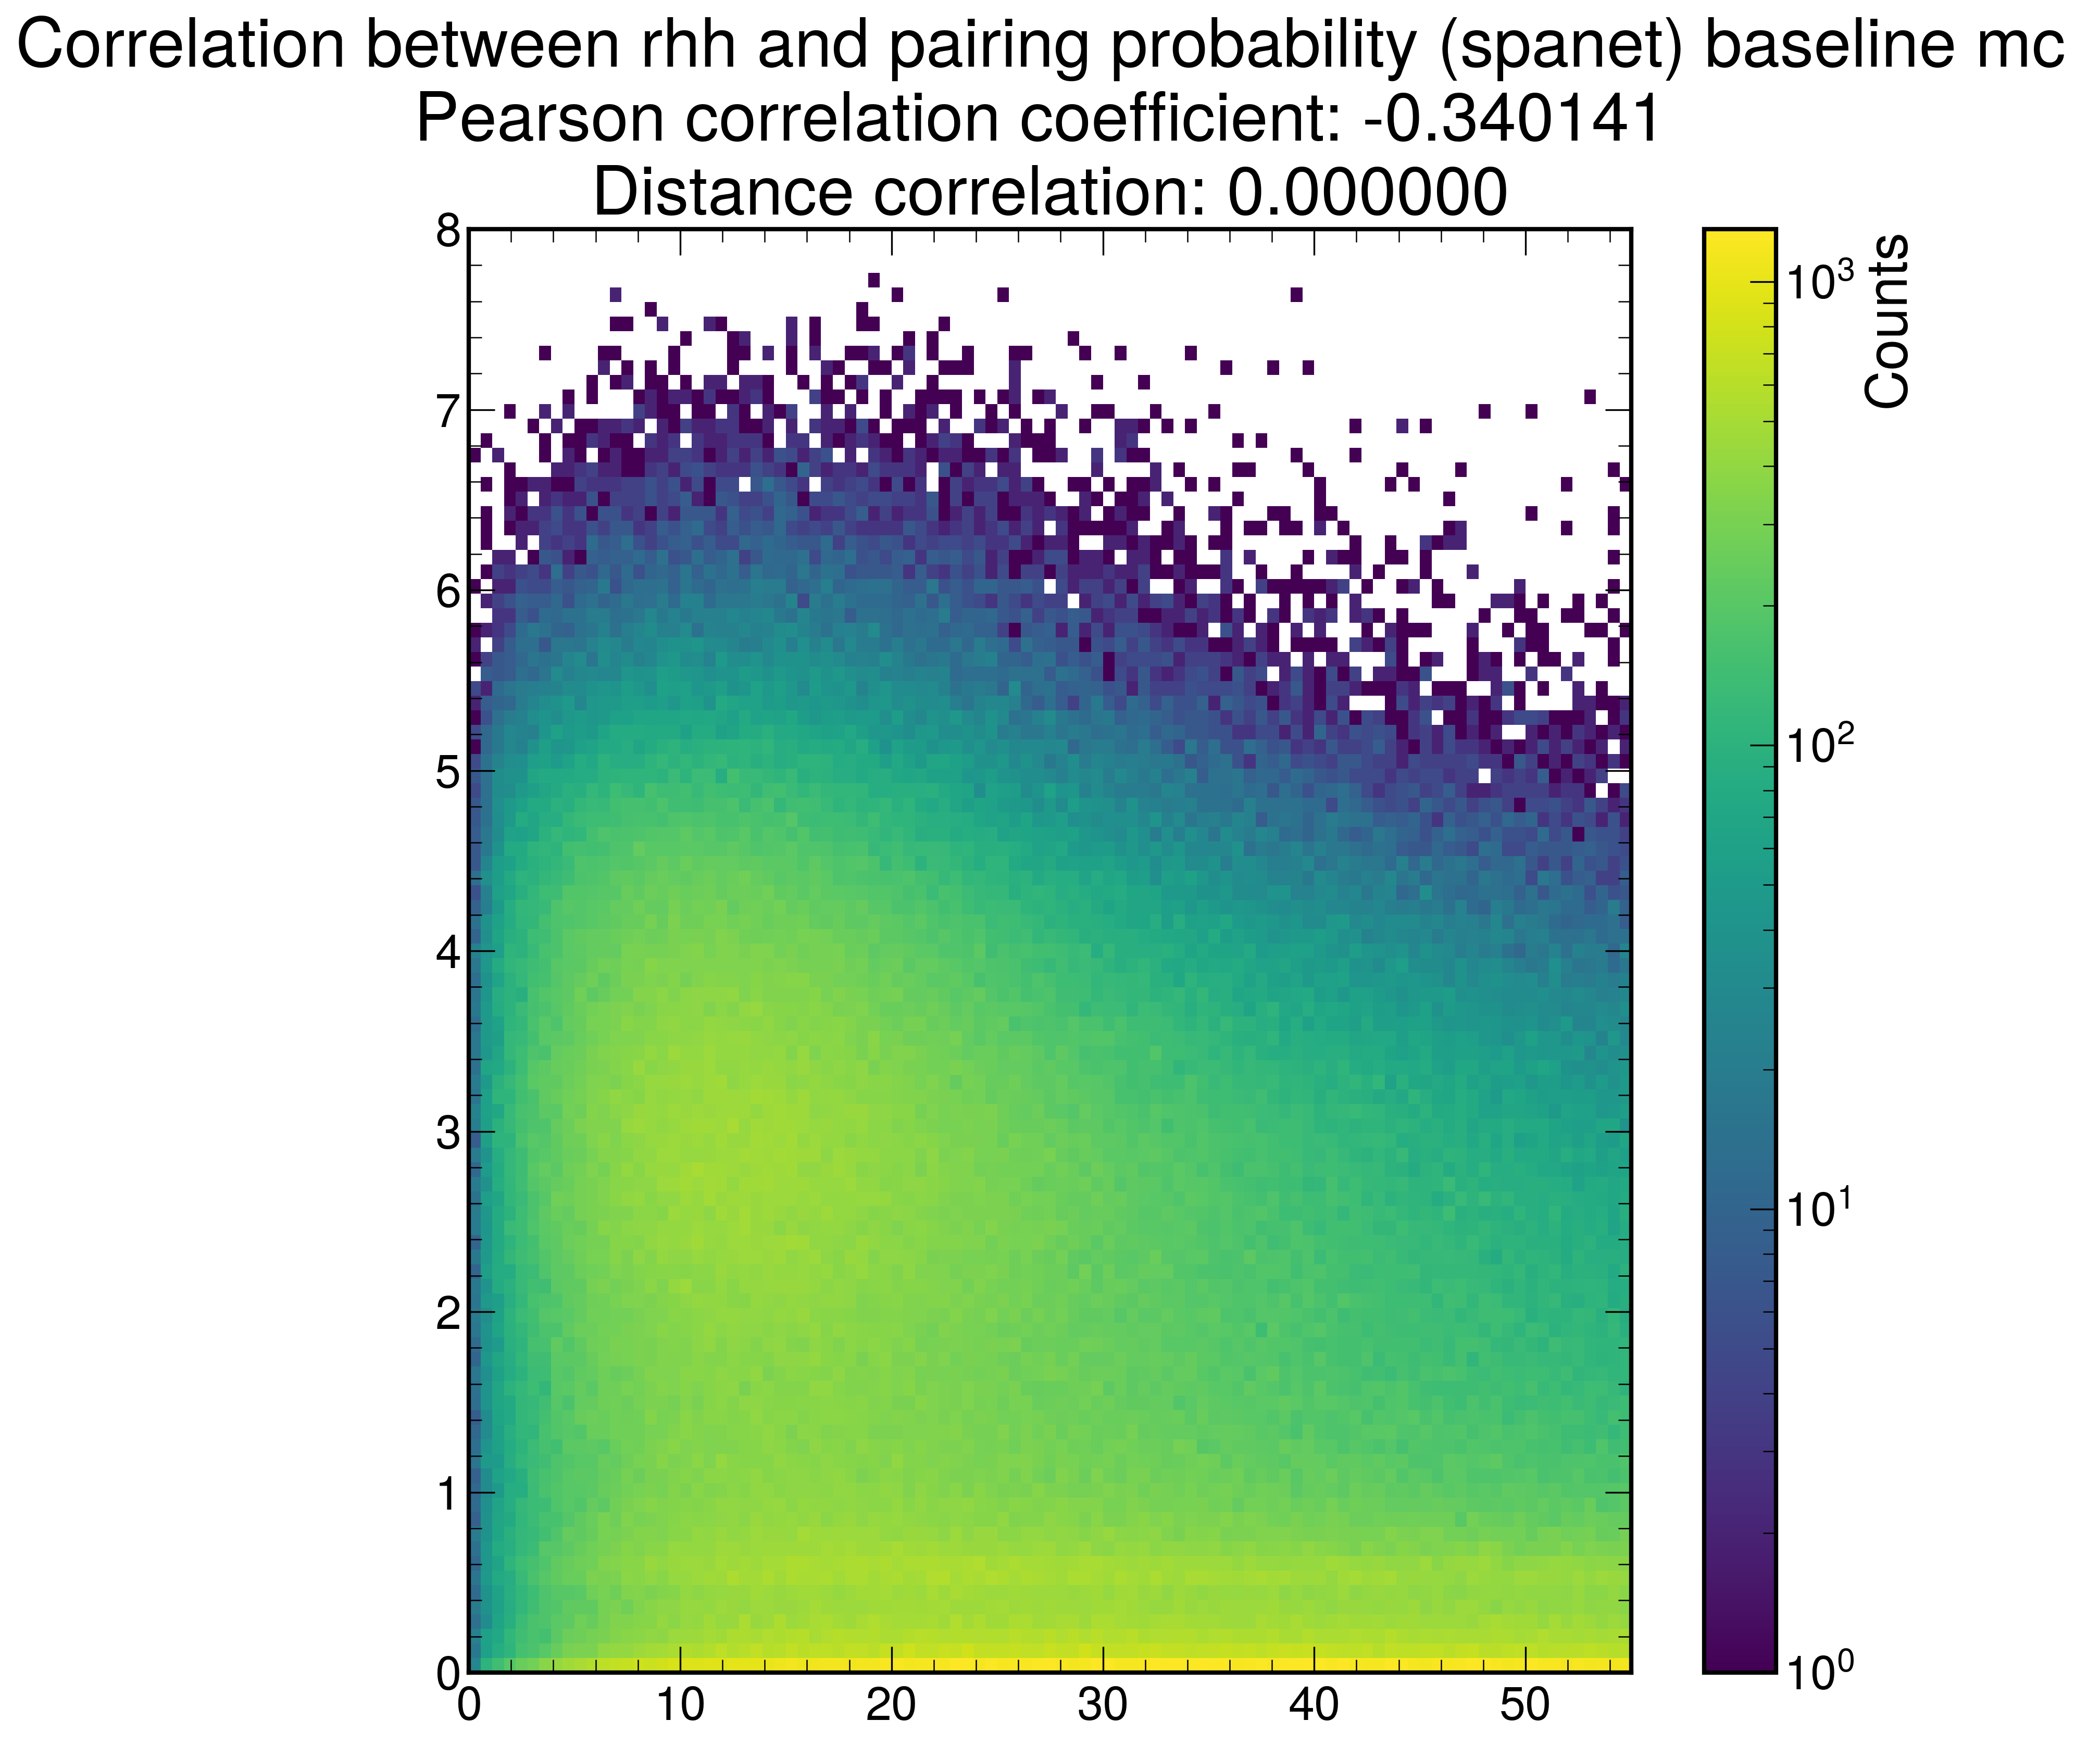

Pearson correlation coefficient (spanet ): -0.323406


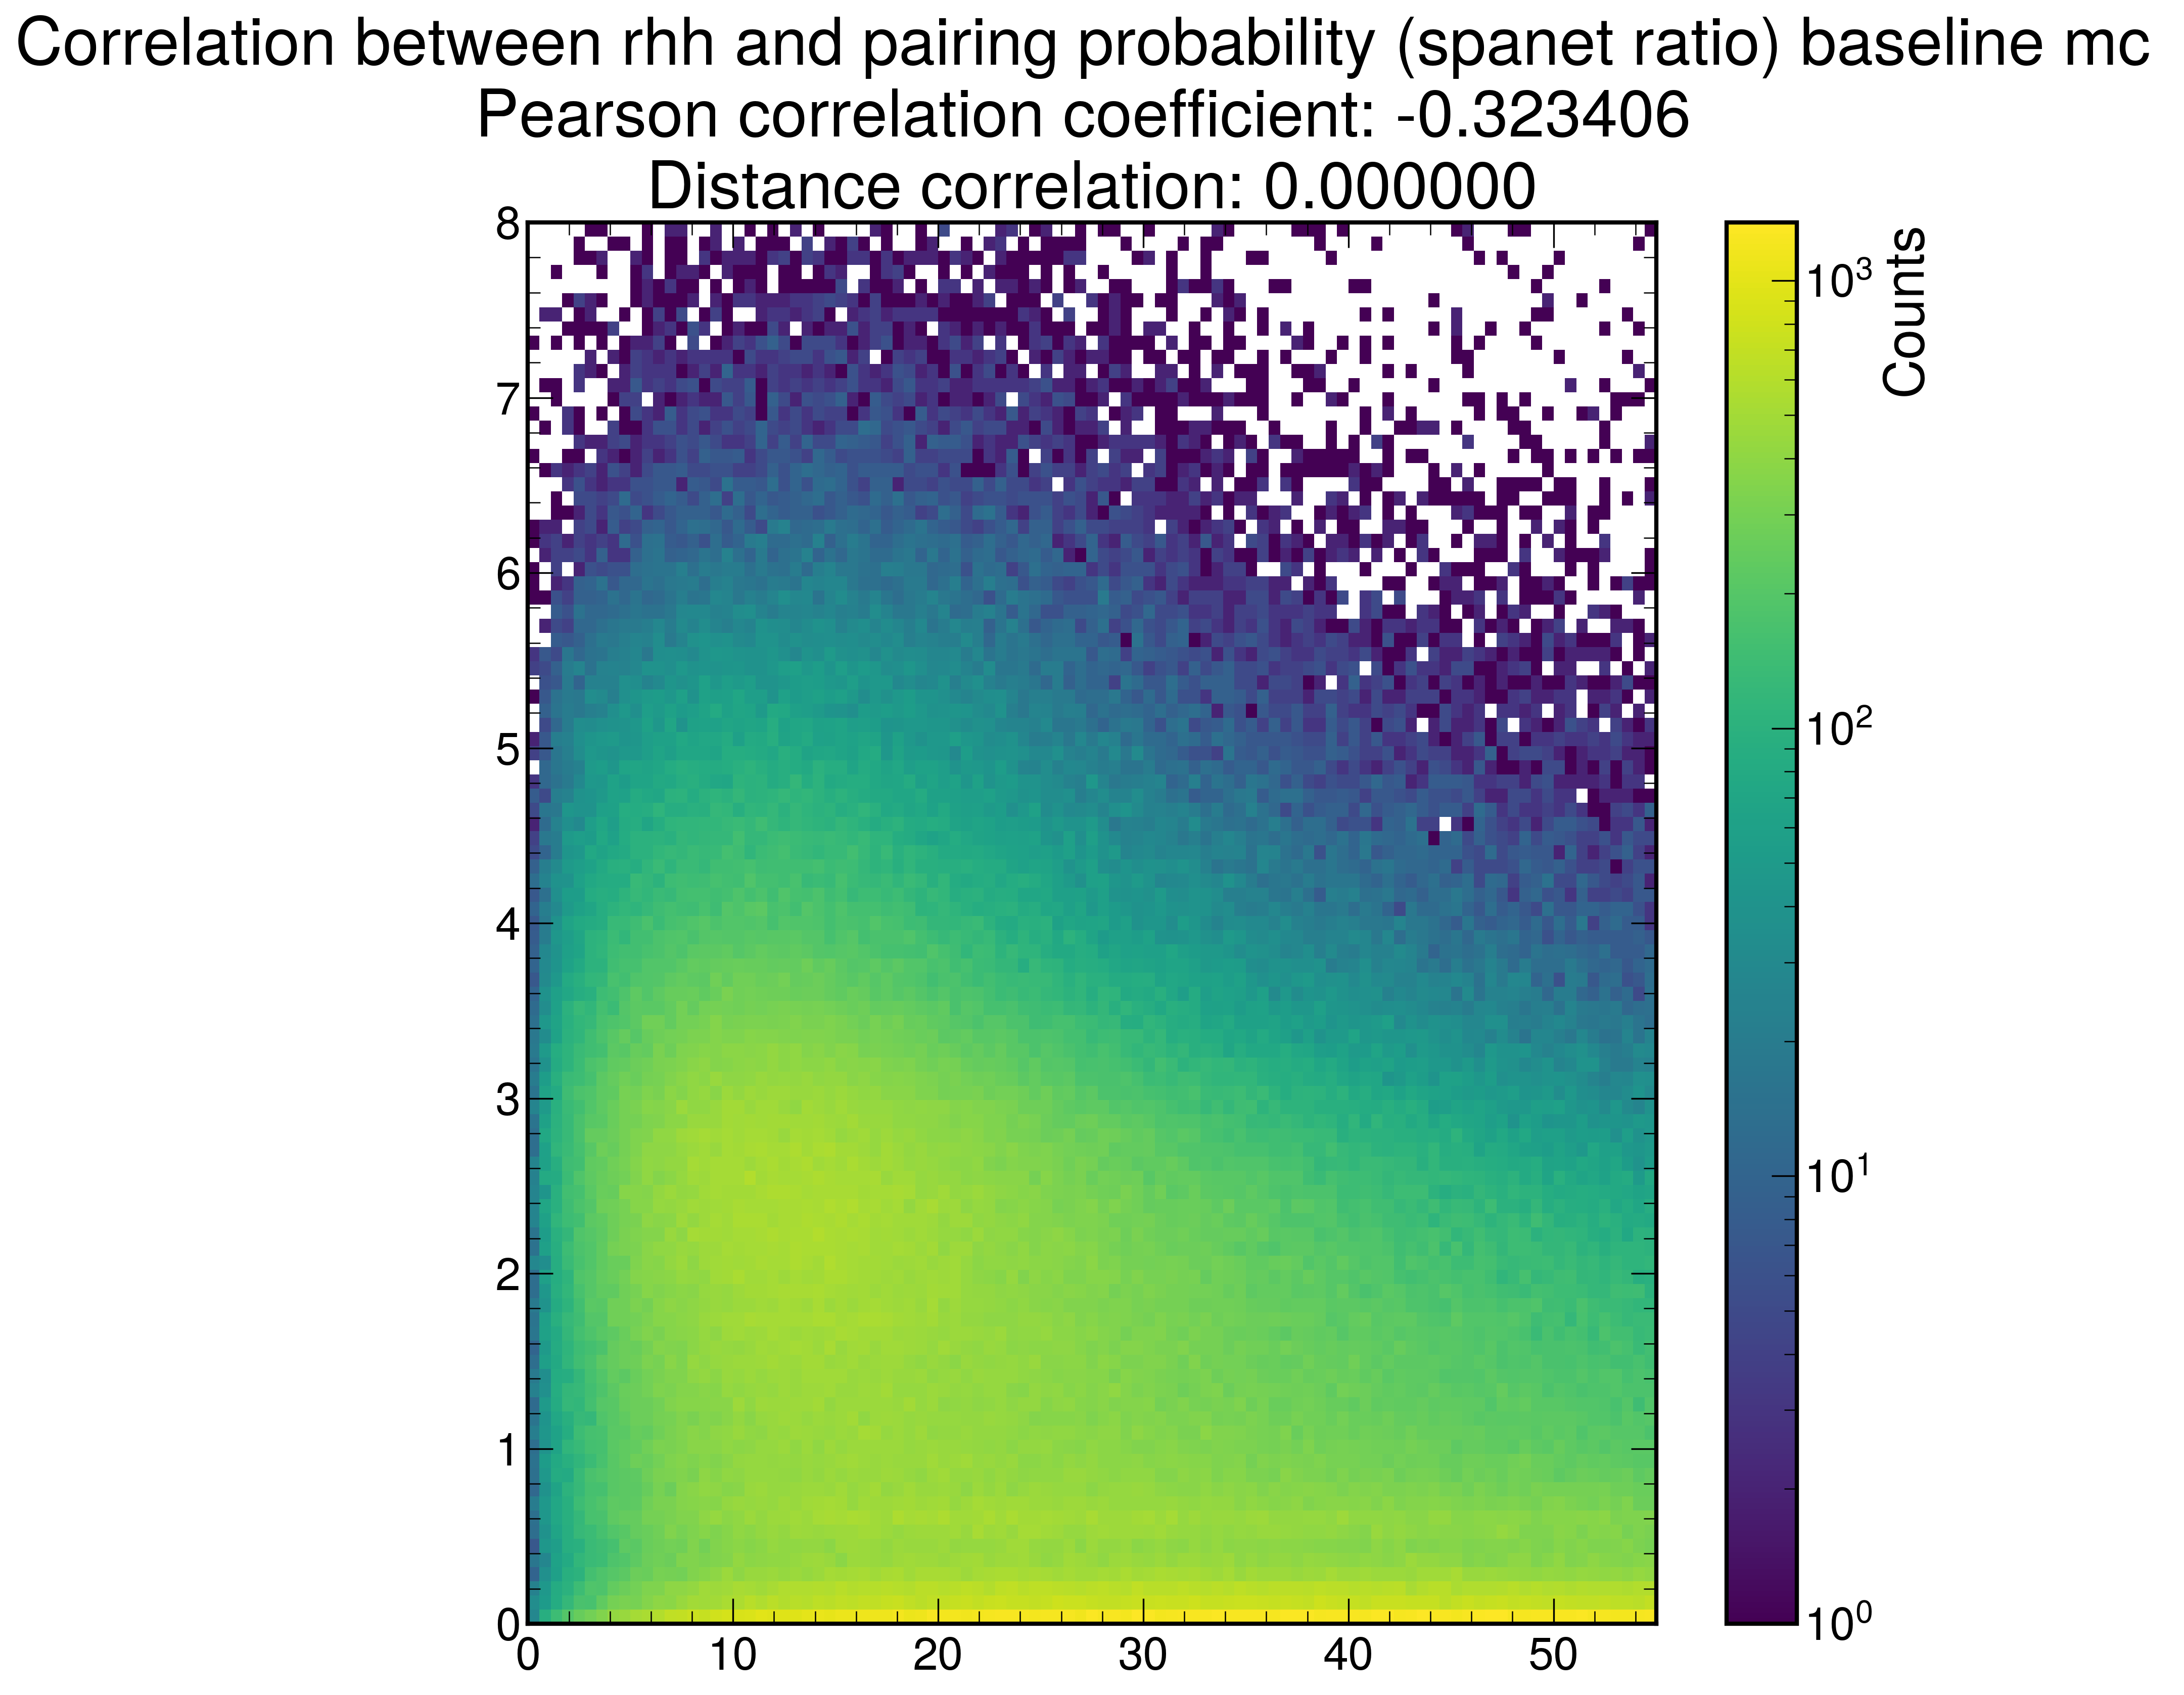

In [9]:
bins_2d=(np.linspace(0, 55, 100), np.linspace(0, 8, 100))
correlation_plot(rhh, pd_spanet, "Correlation between rhh and pairing probability (spanet) baseline",bins_2d)
correlation_plot(rhh_ratio, pd_spanet_ratio, "Correlation between rhh and pairing probability (spanet ratio) baseline",bins_2d)
correlation_plot(rhh_mc, pd_spanet_mc, "Correlation between rhh and pairing probability (spanet) baseline mc",bins_2d)
correlation_plot(rhh_ratio_mc, pd_spanet_ratio_mc, "Correlation between rhh and pairing probability (spanet ratio) baseline mc", bins_2d)

# Rhh vs btag

Pearson correlation coefficient (spanet ): -0.039290


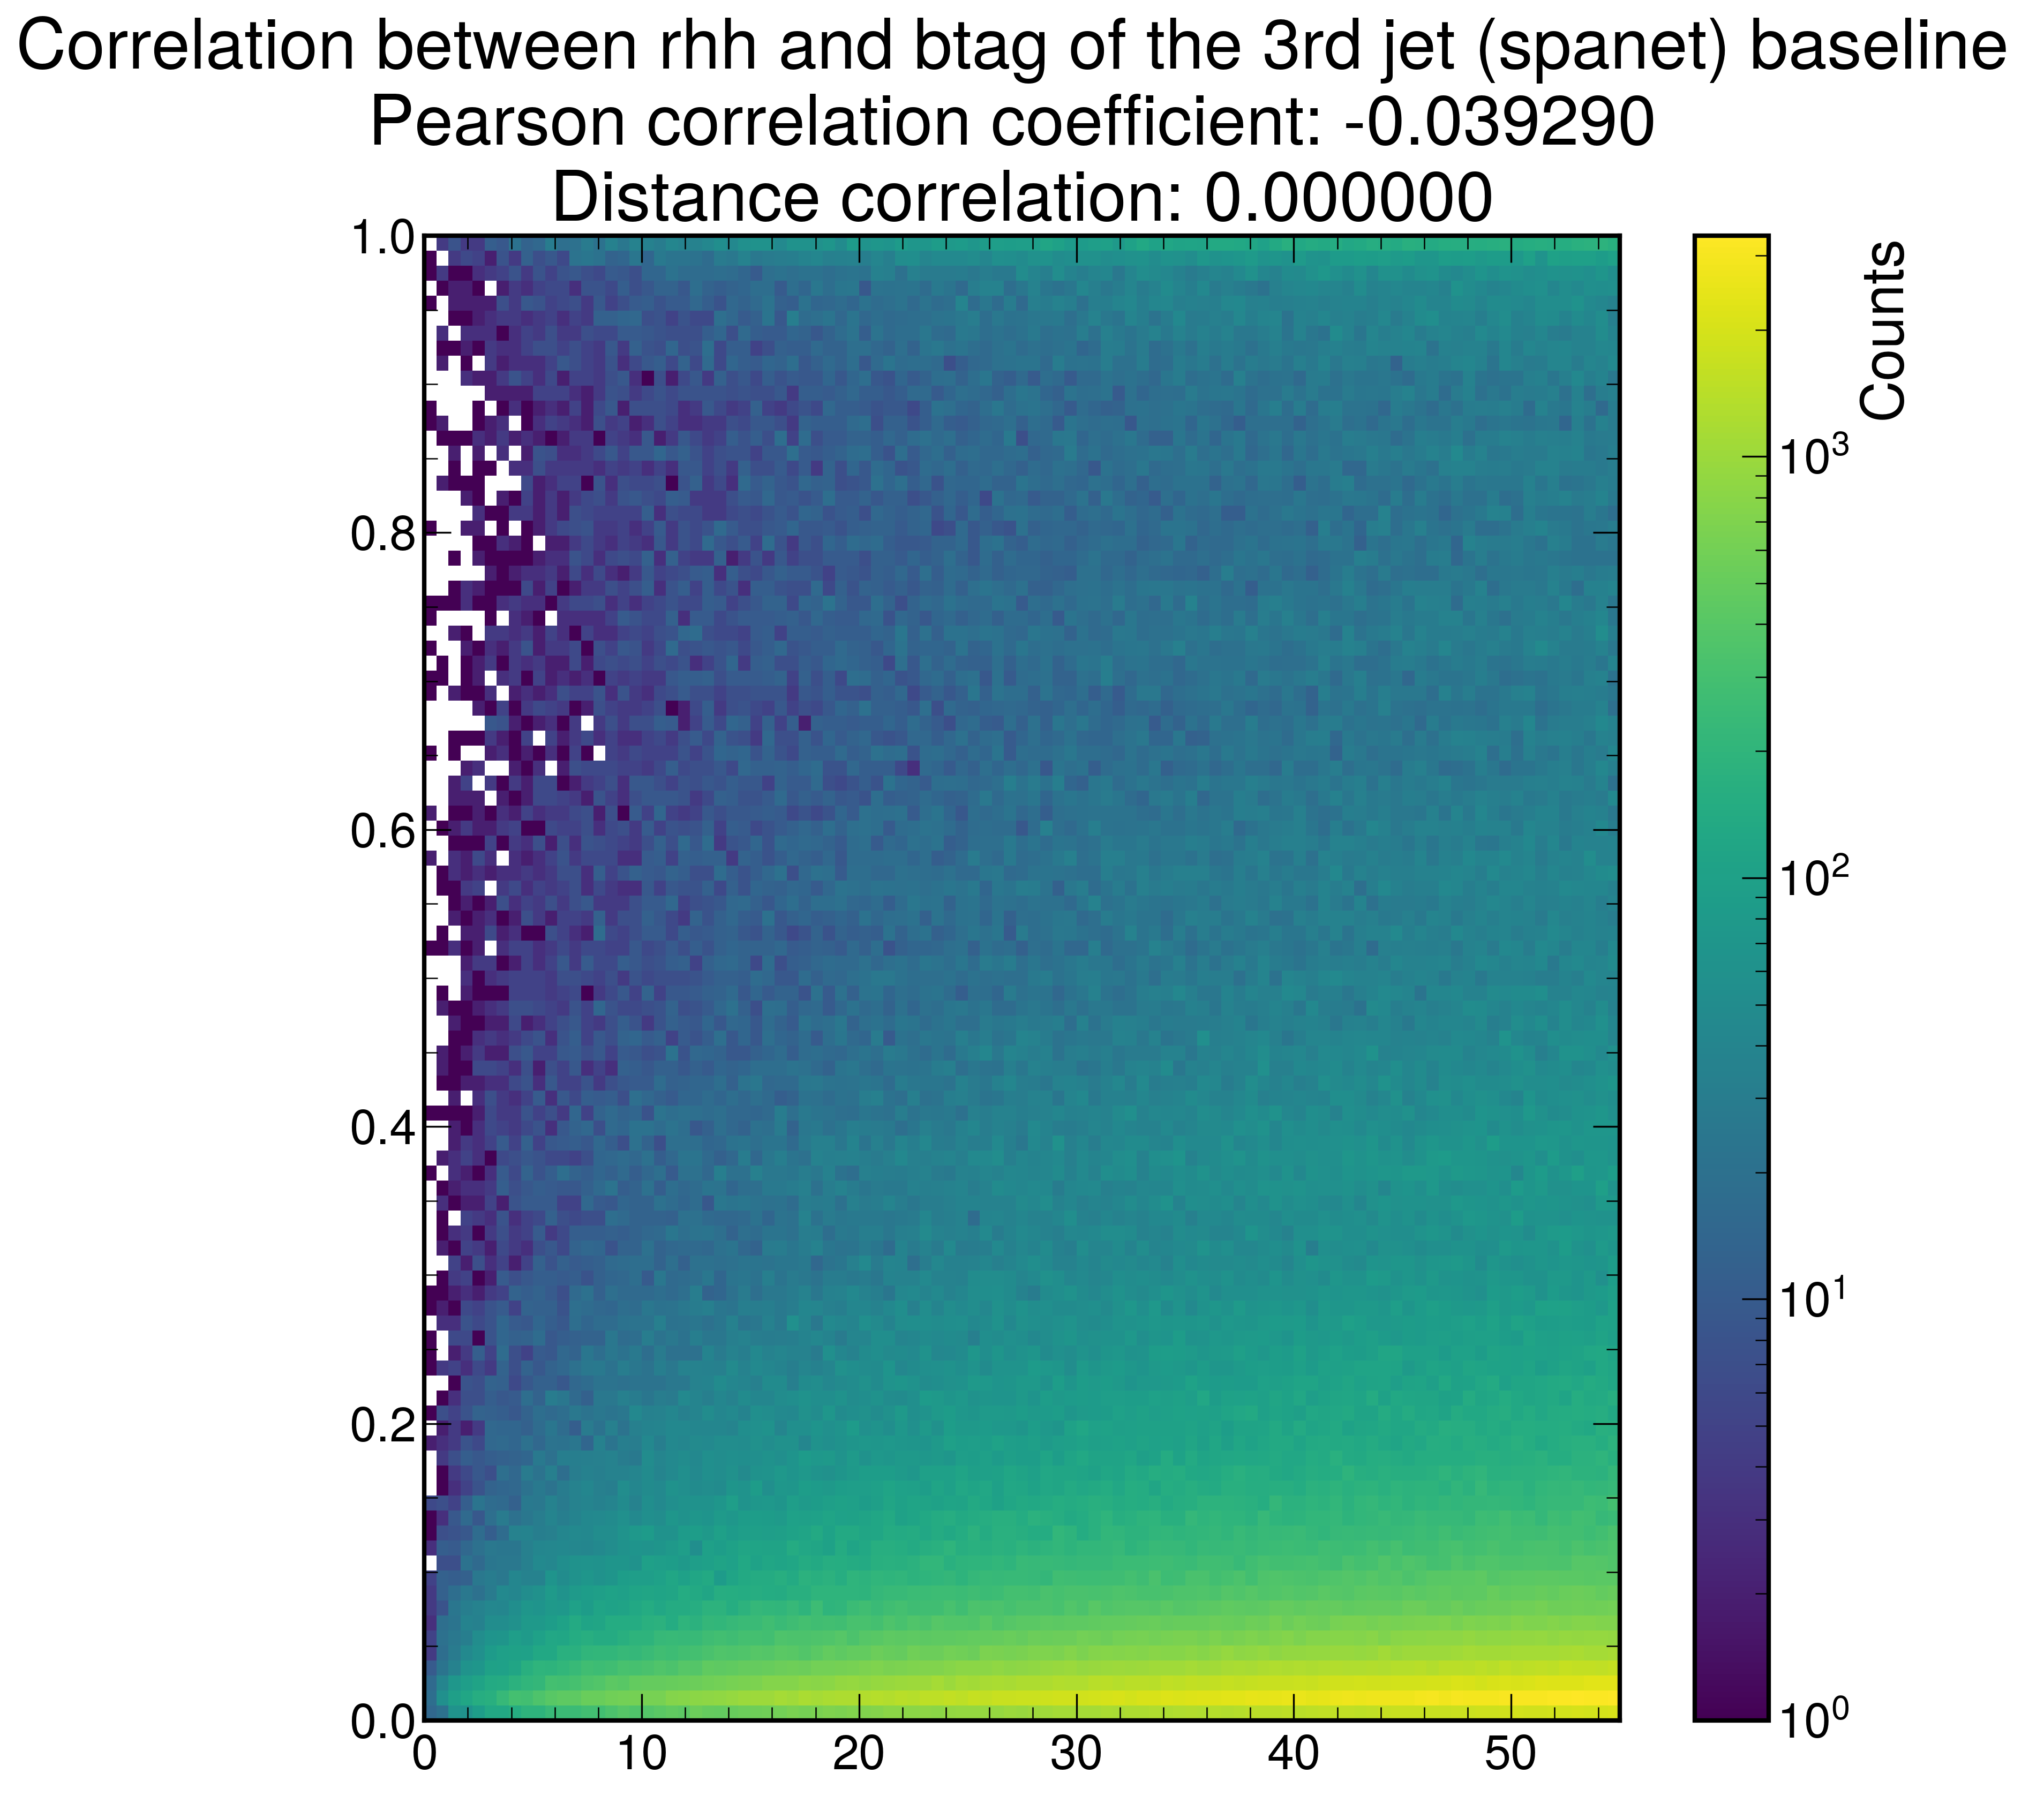

Pearson correlation coefficient (spanet ): -0.008839


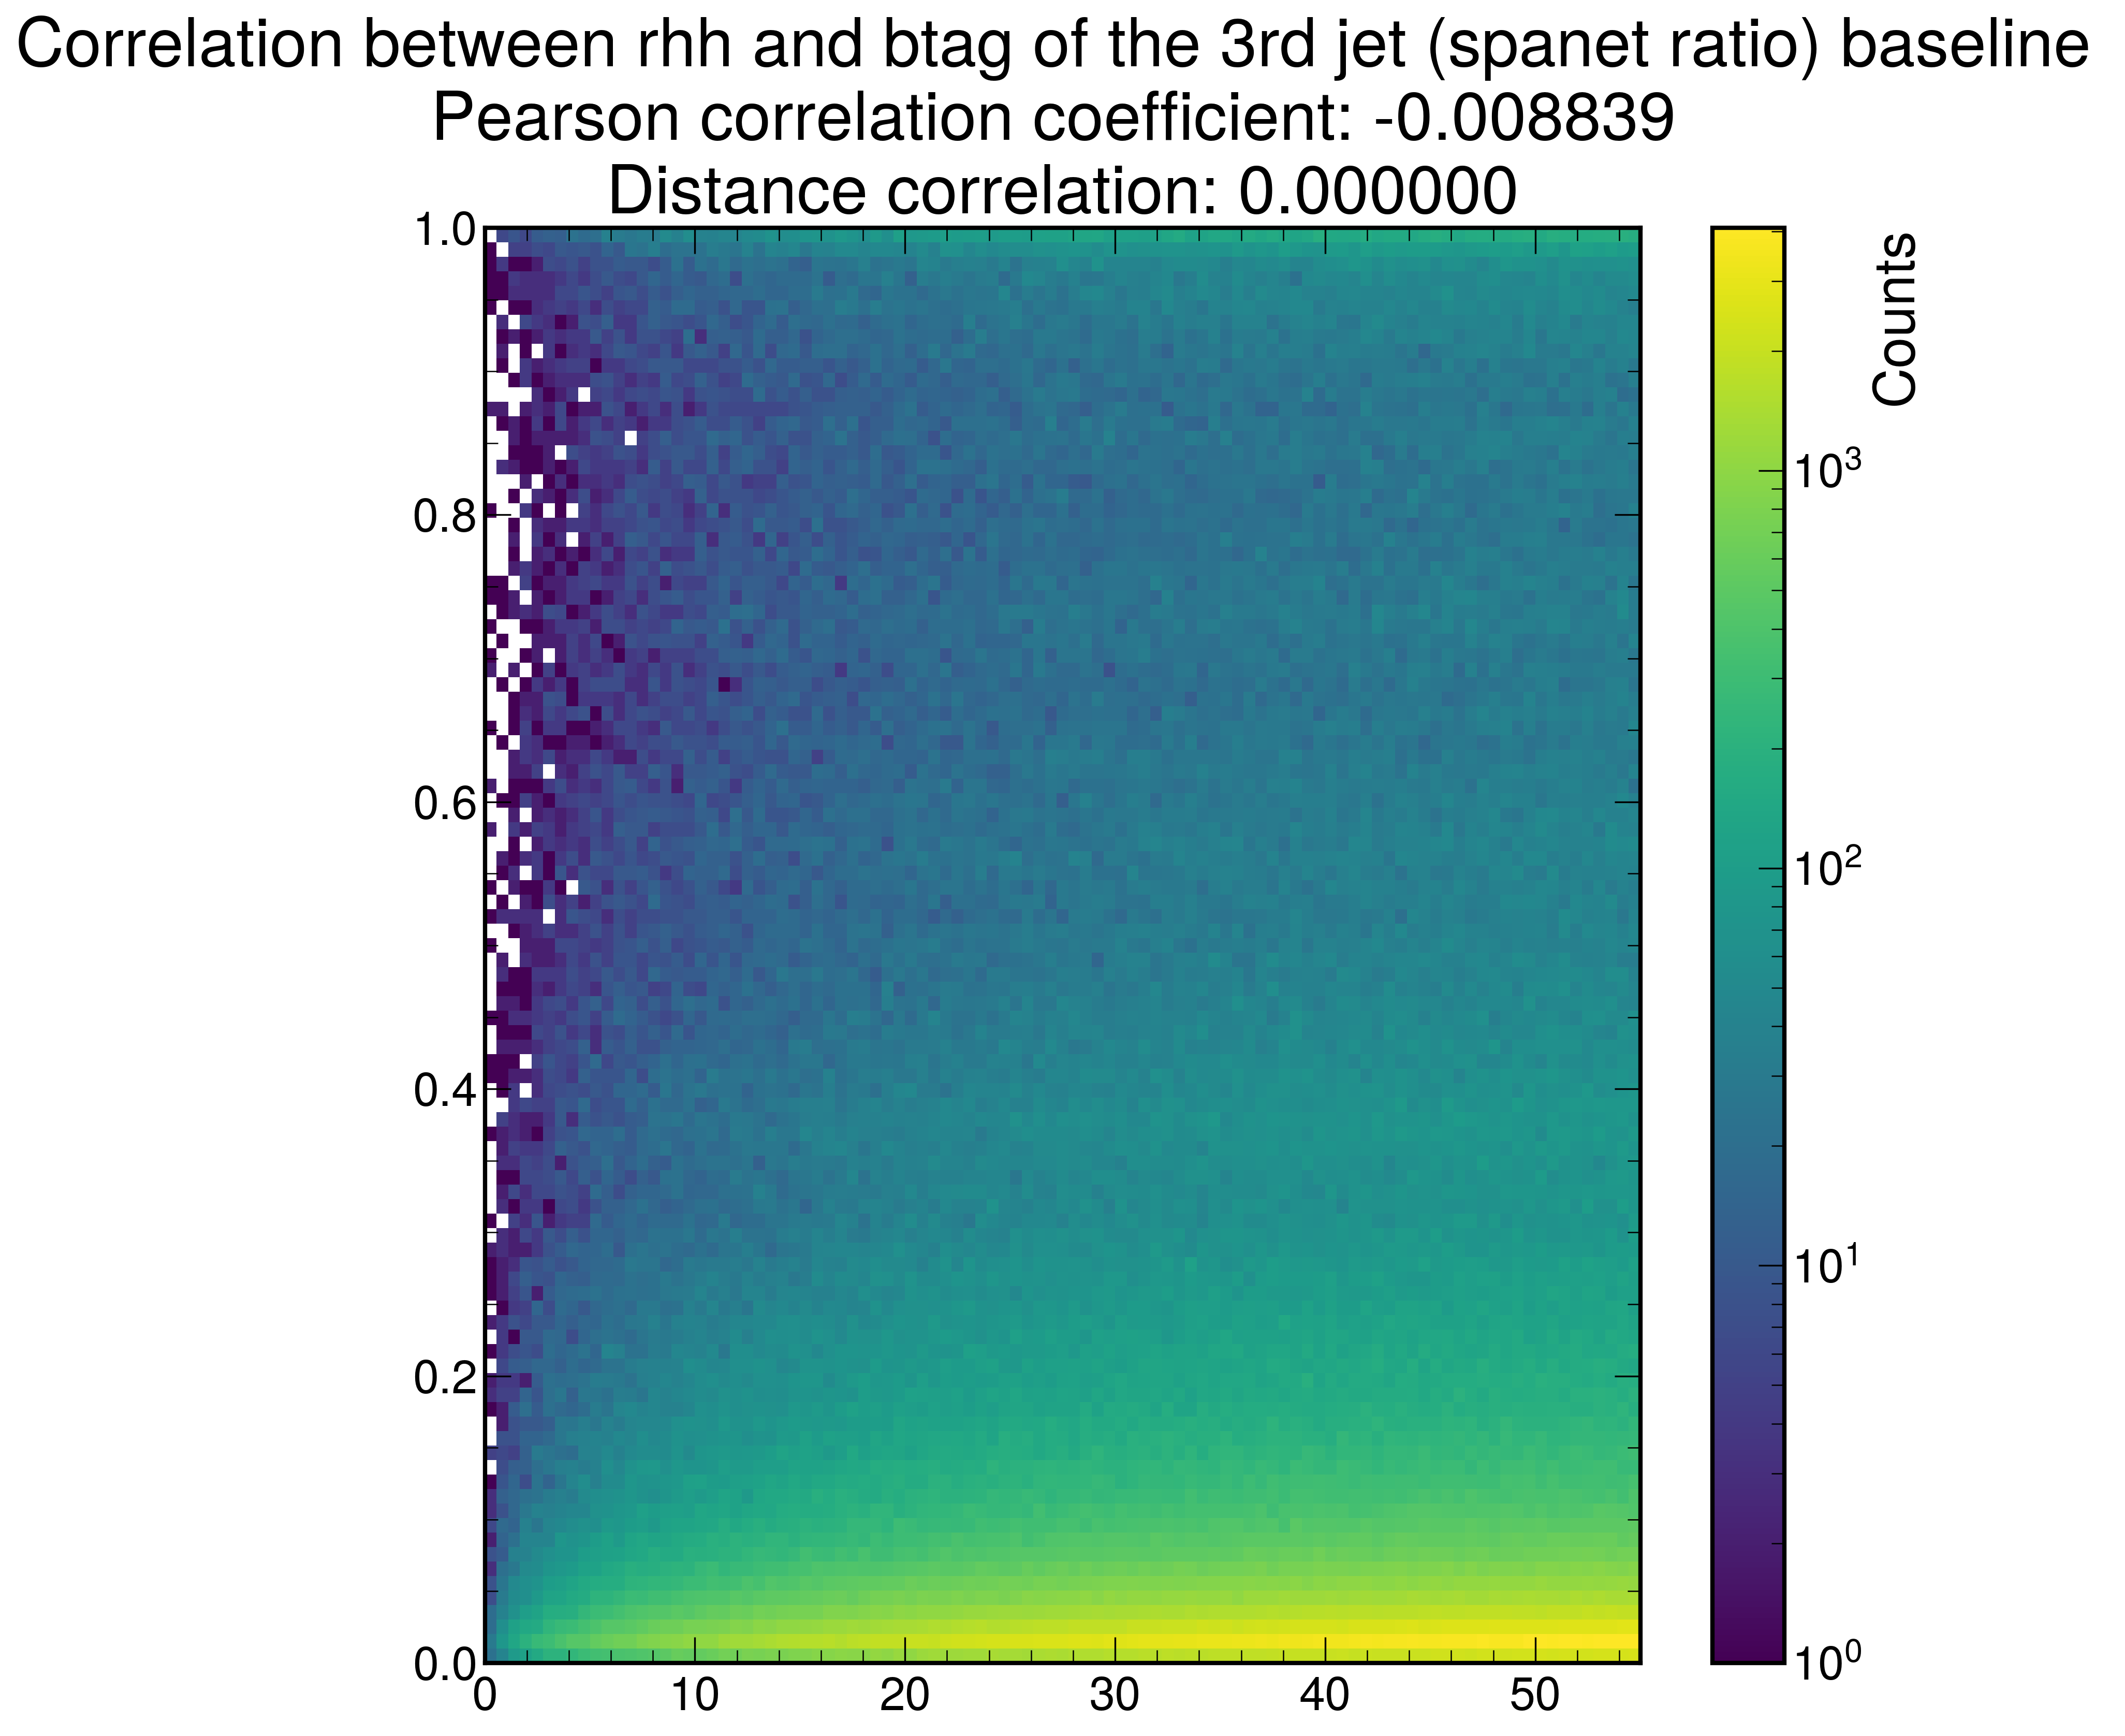

Pearson correlation coefficient (spanet ): -0.197334


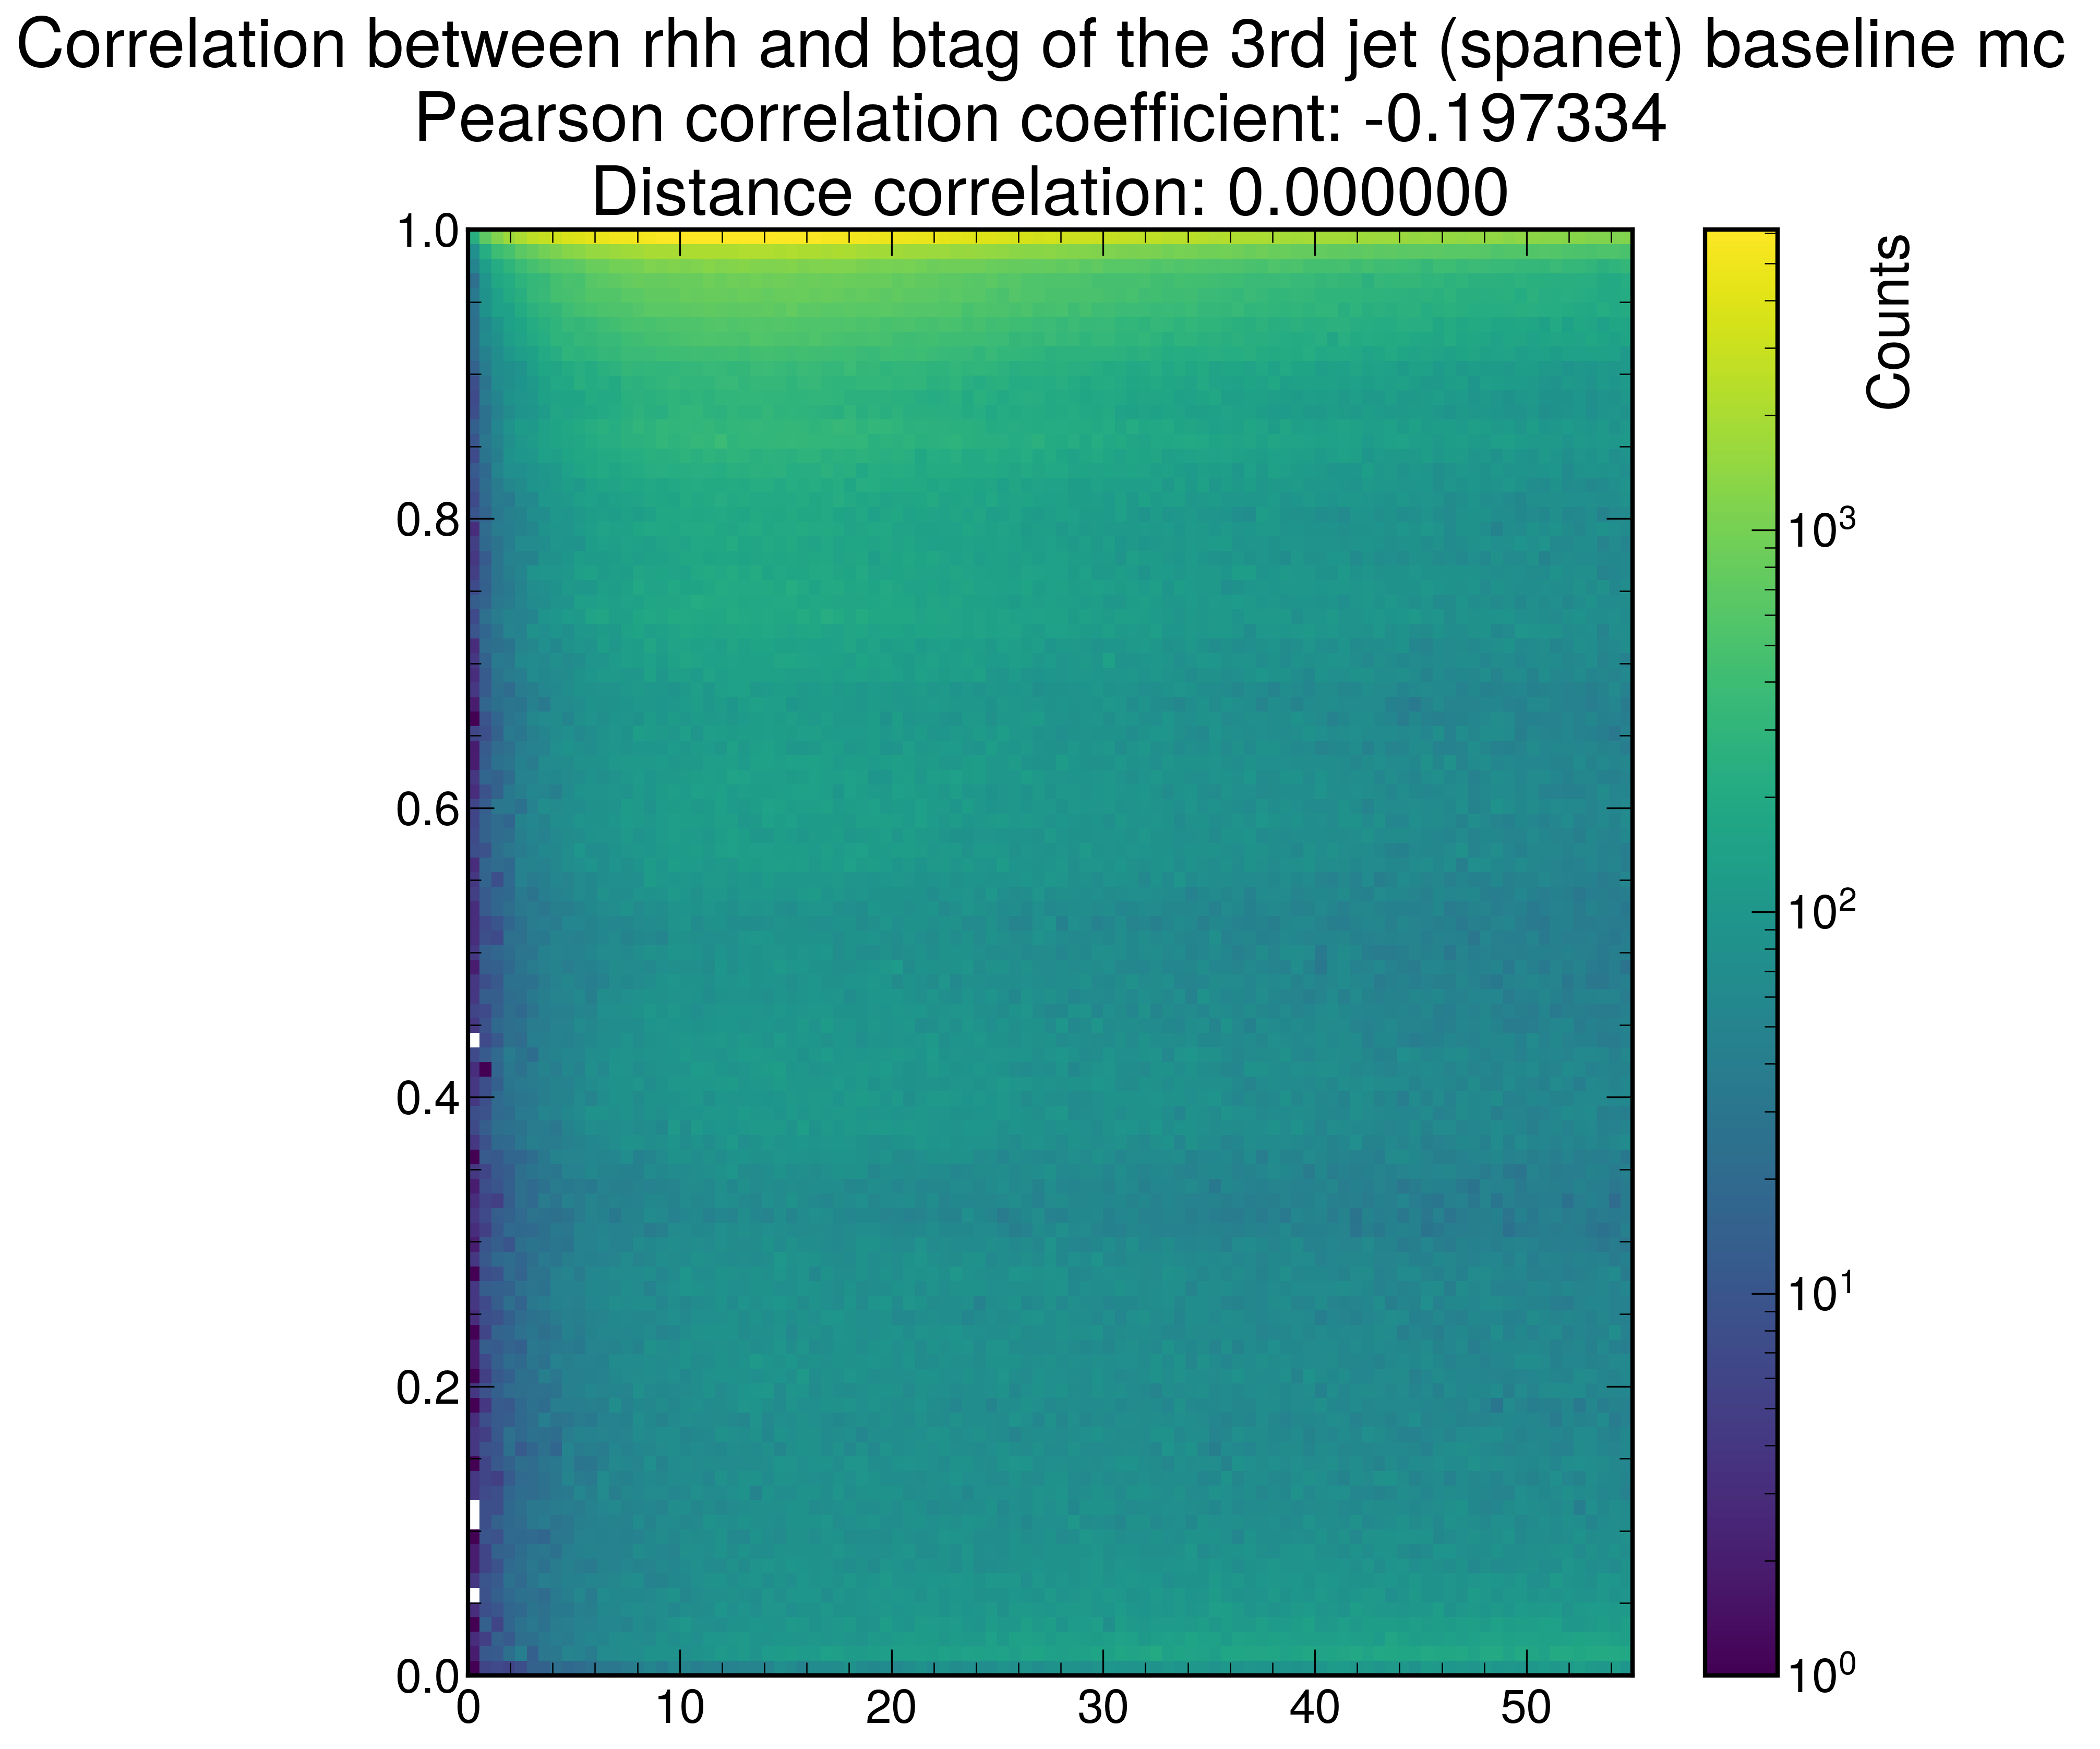

Pearson correlation coefficient (spanet ): -0.174533


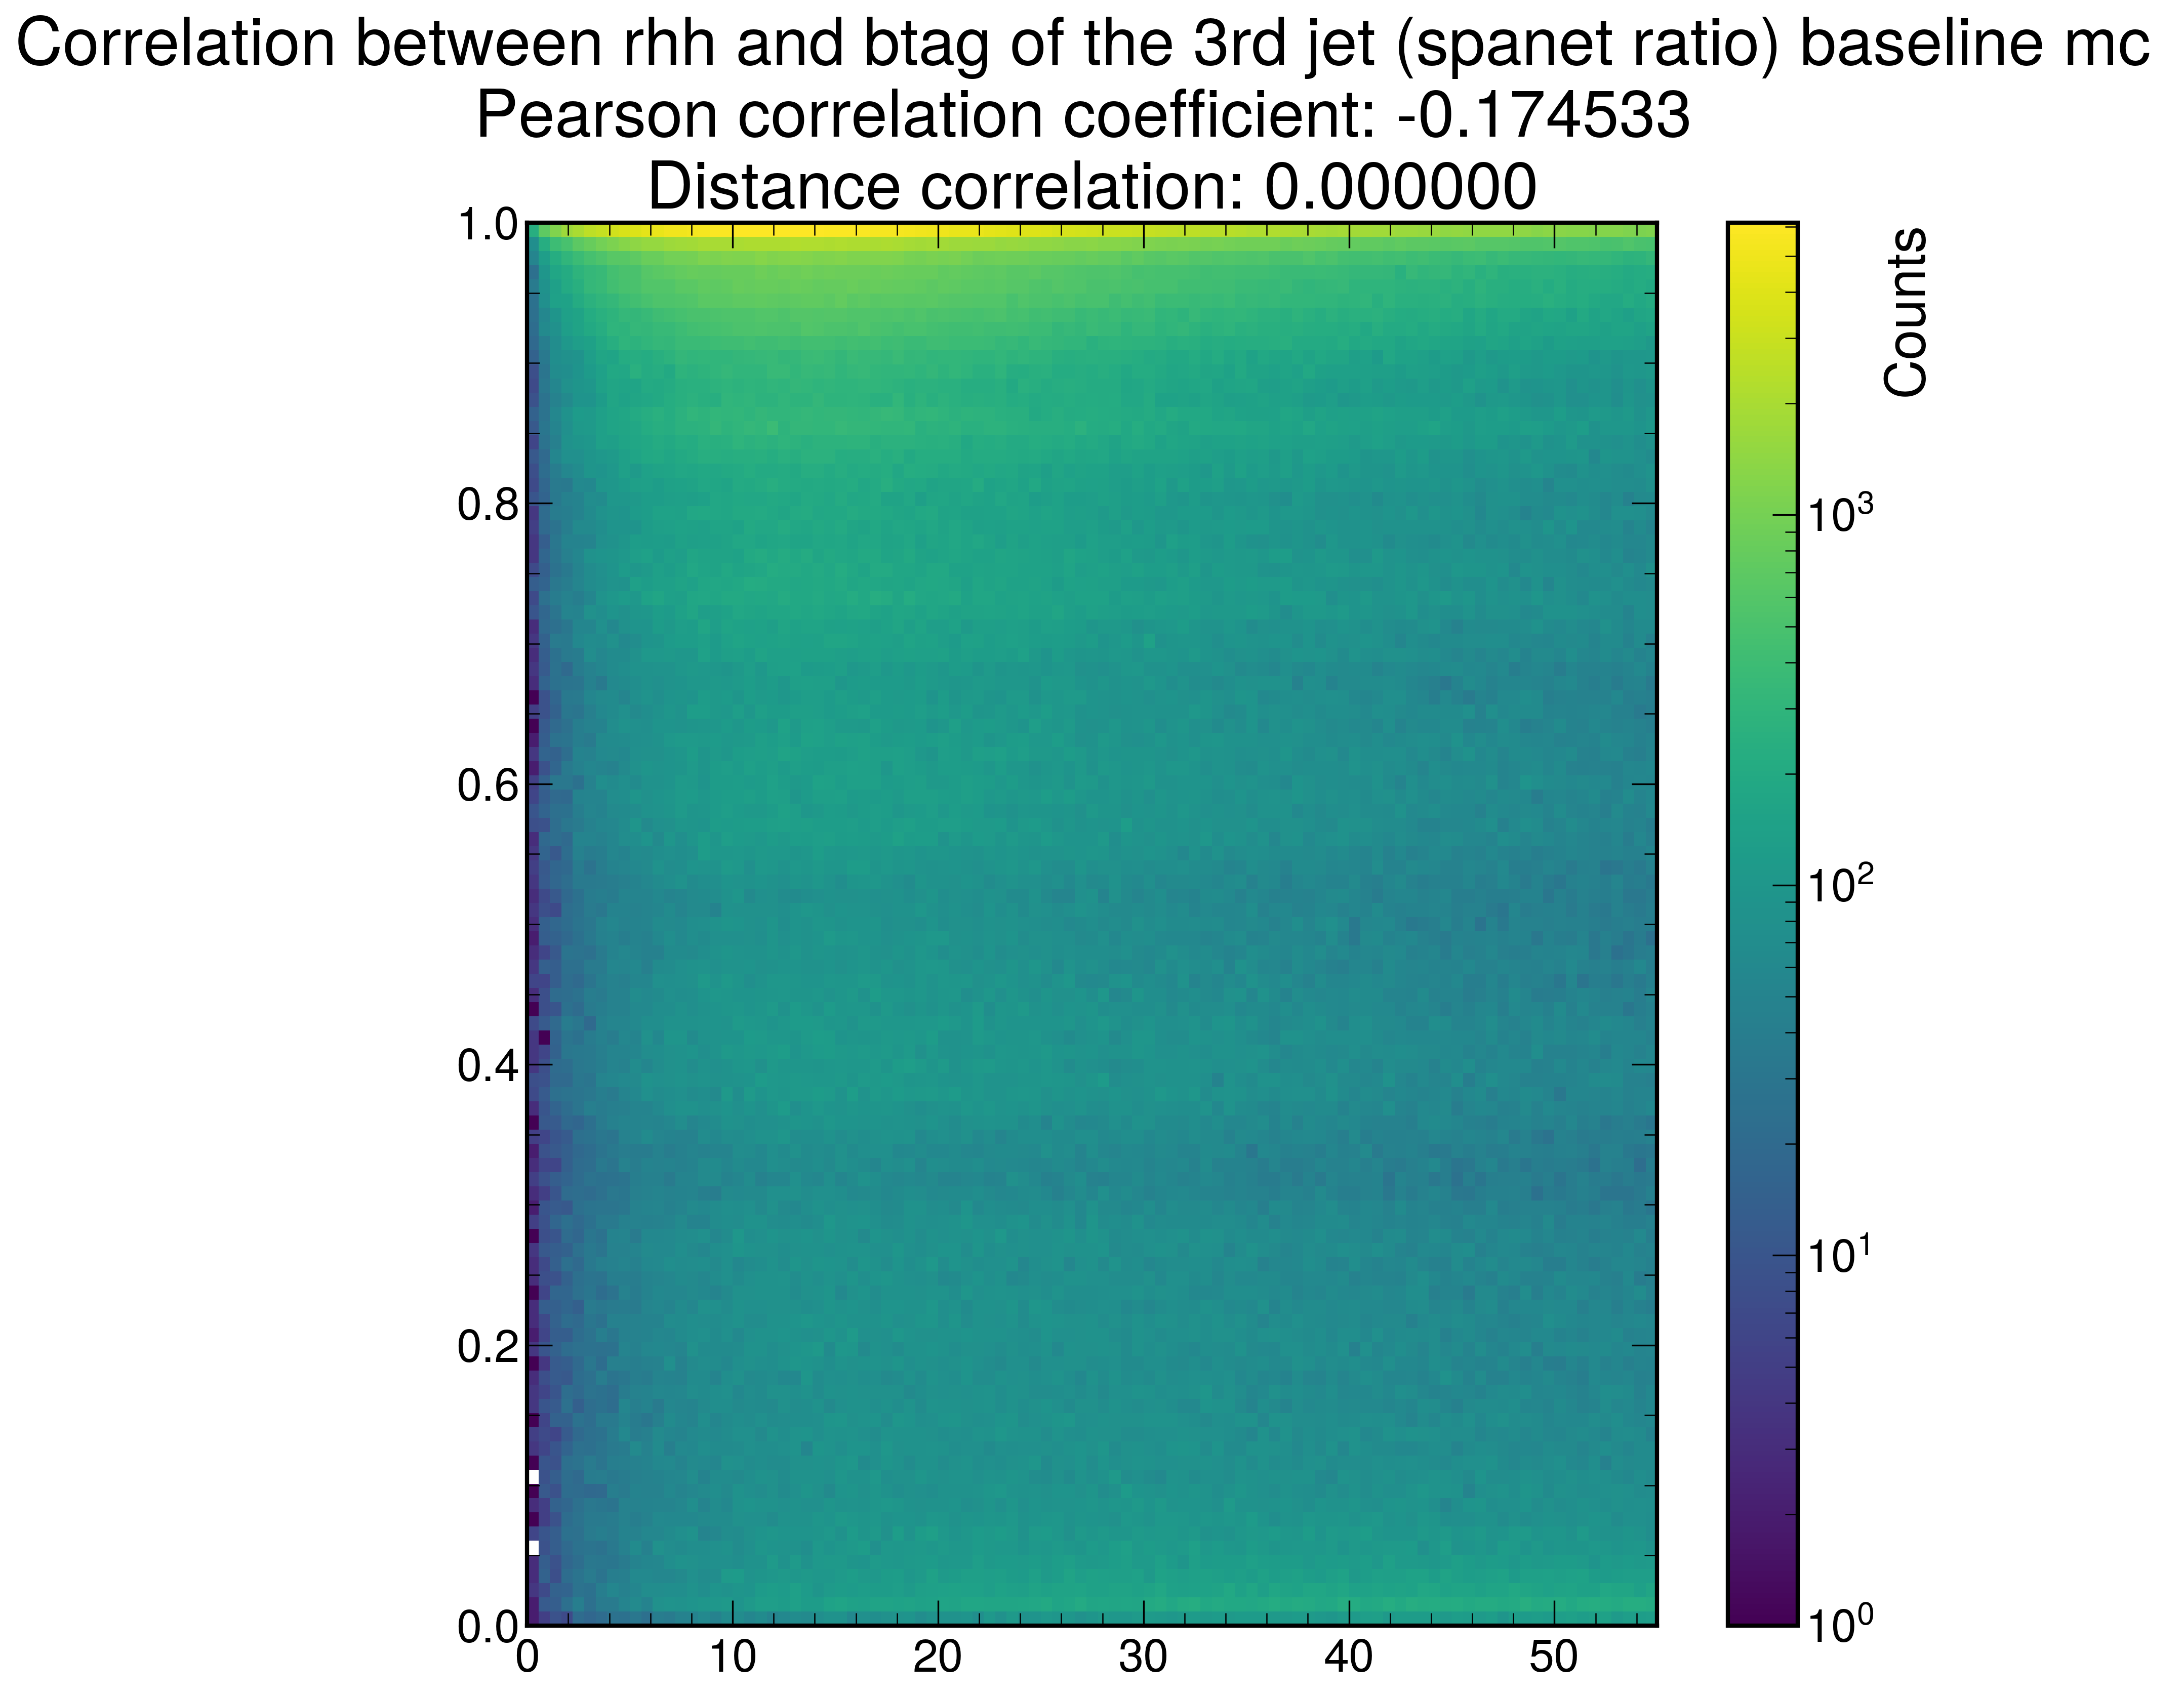

In [10]:
bins_2d=(np.linspace(0, 55, 100),np.linspace(0, 1, 100))


correlation_plot(rhh, btag_spanet_unflattened[:,2],    "Correlation between rhh and btag of the 3rd jet (spanet) "+REGION, bins_2d)
correlation_plot( rhh_ratio, btag_spanet_ratio_unflattened[:,2],   "Correlation between rhh and btag of the 3rd jet (spanet ratio) "+REGION, bins_2d)
correlation_plot(rhh_mc, btag_spanet_mc_unflattened[:,2],    "Correlation between rhh and btag of the 3rd jet (spanet) "+REGION+" mc", bins_2d)
correlation_plot( rhh_ratio_mc, btag_spanet_ratio_mc_unflattened[:,2],   "Correlation between rhh and btag of the 3rd jet (spanet ratio) "+REGION+" mc", bins_2d)



Pearson correlation coefficient (spanet ): -0.047799


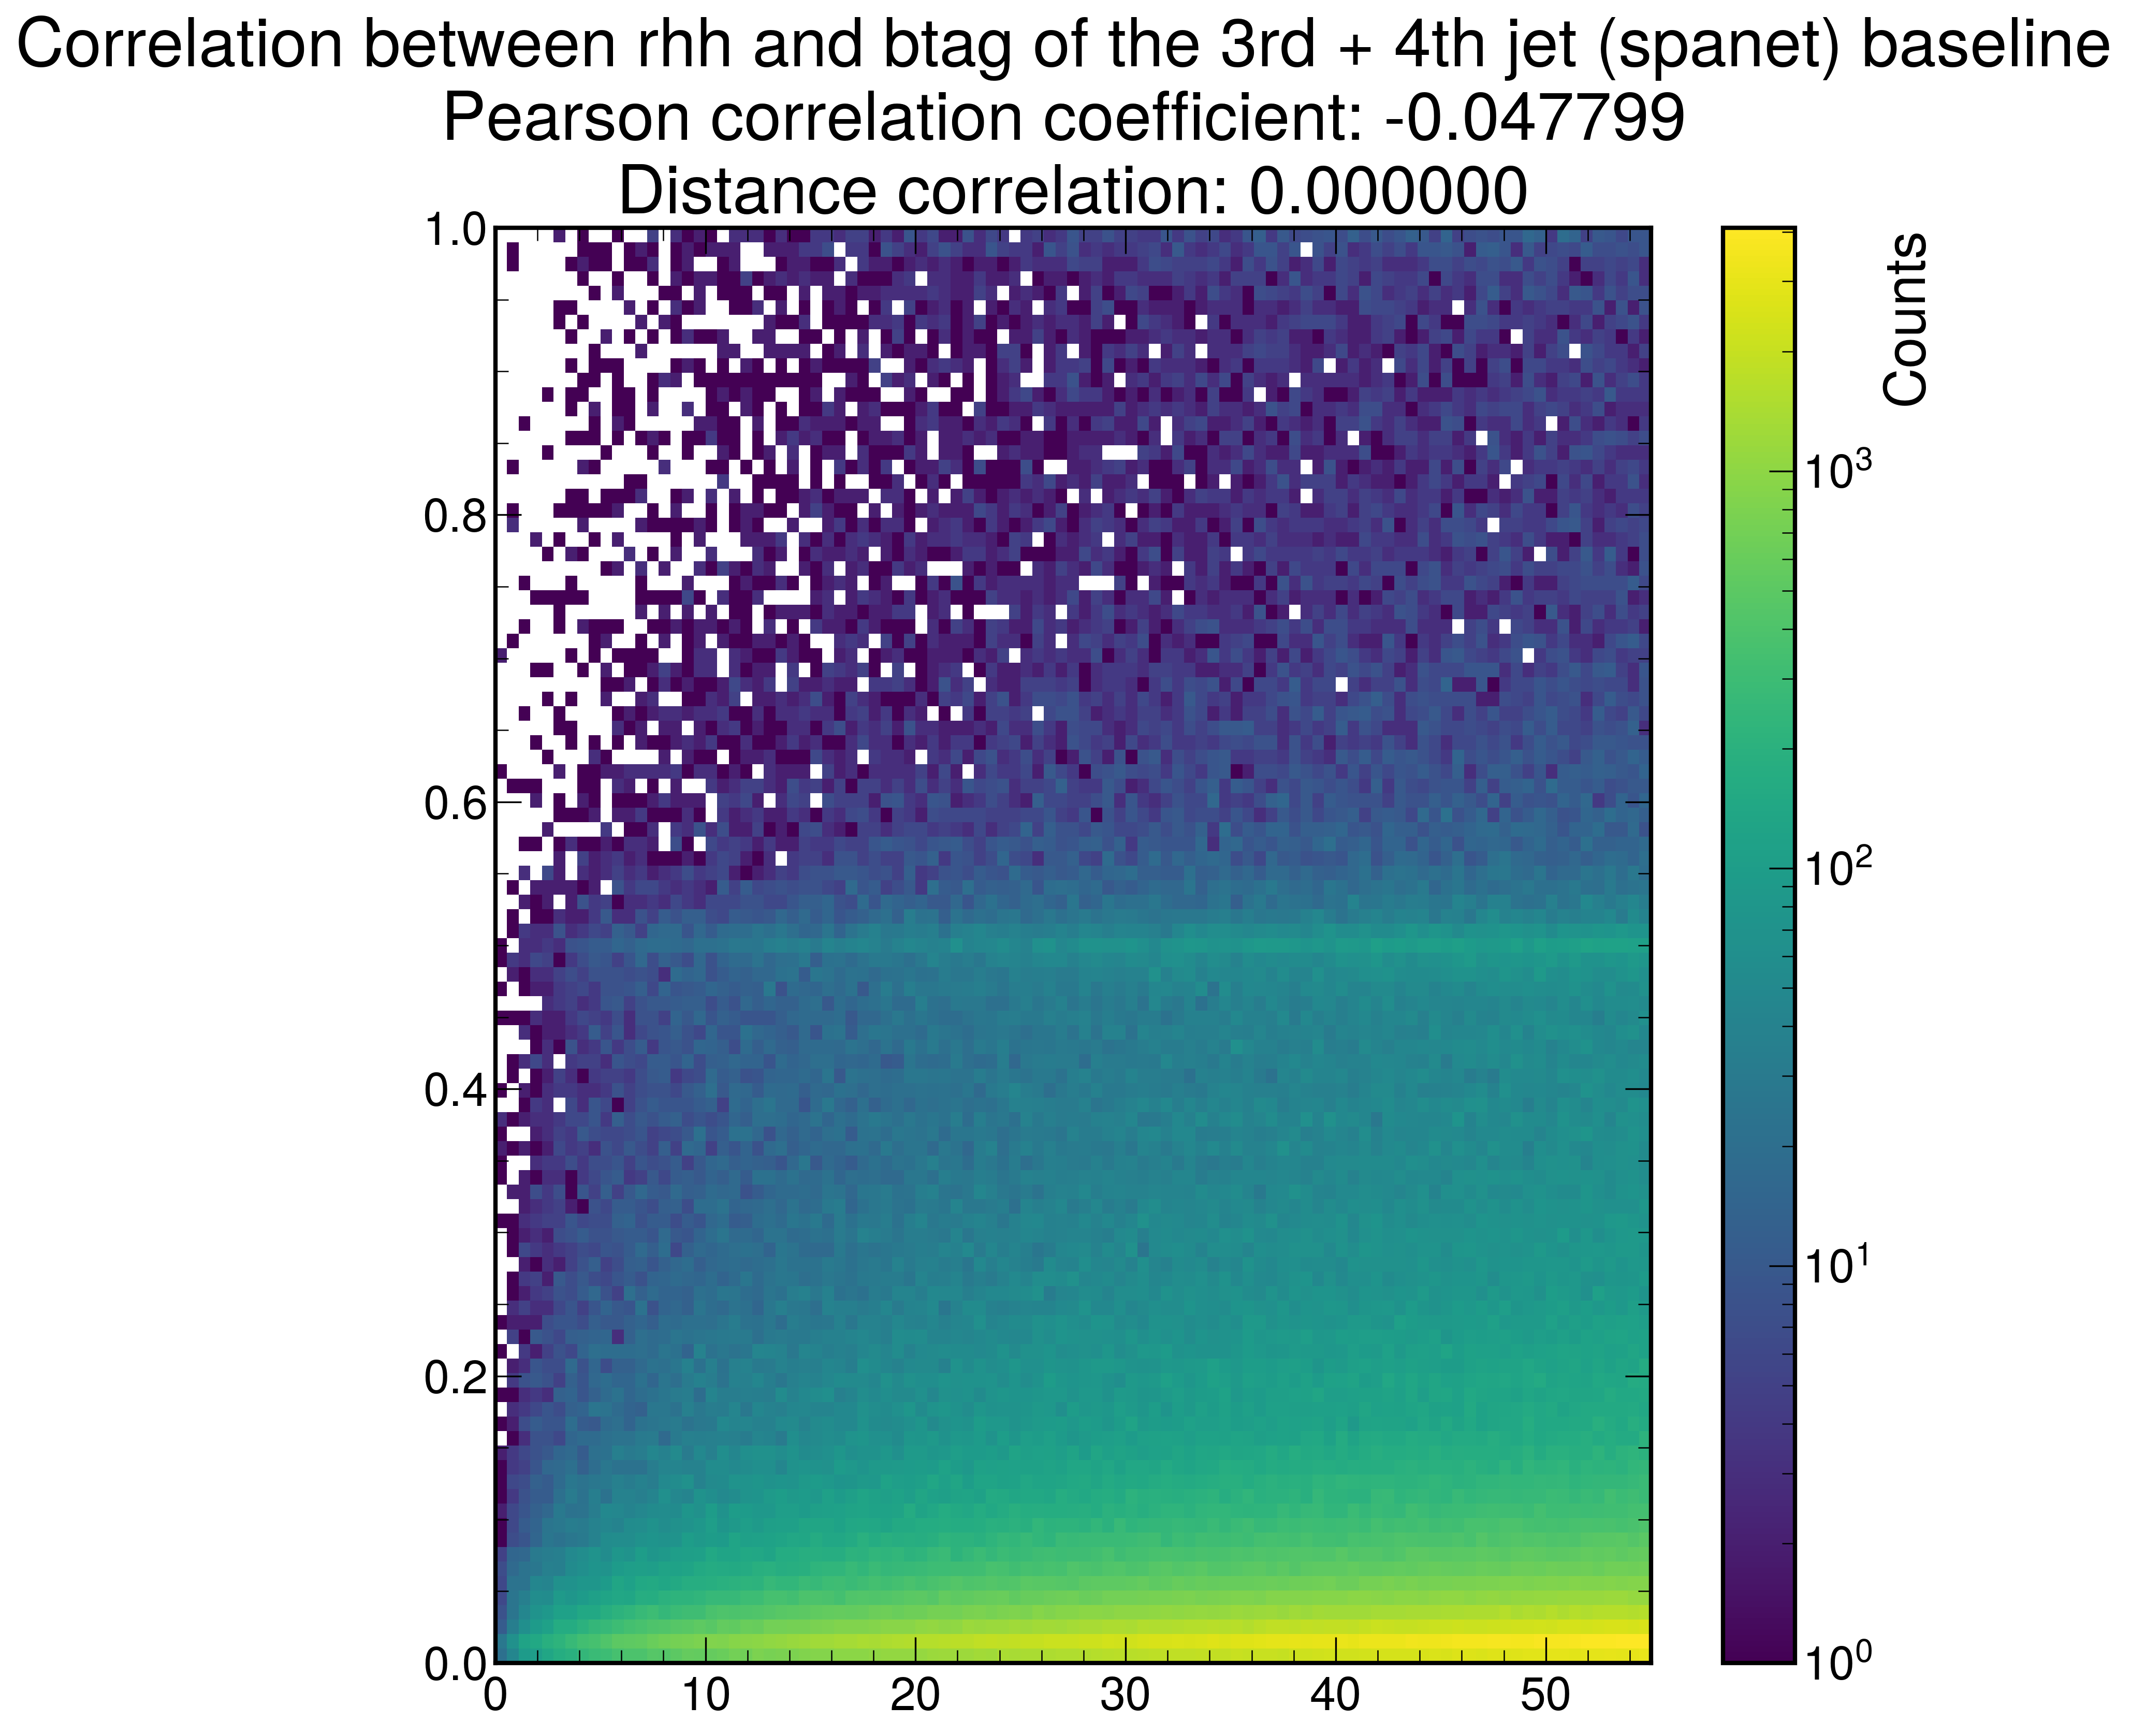

Pearson correlation coefficient (spanet ): -0.020779


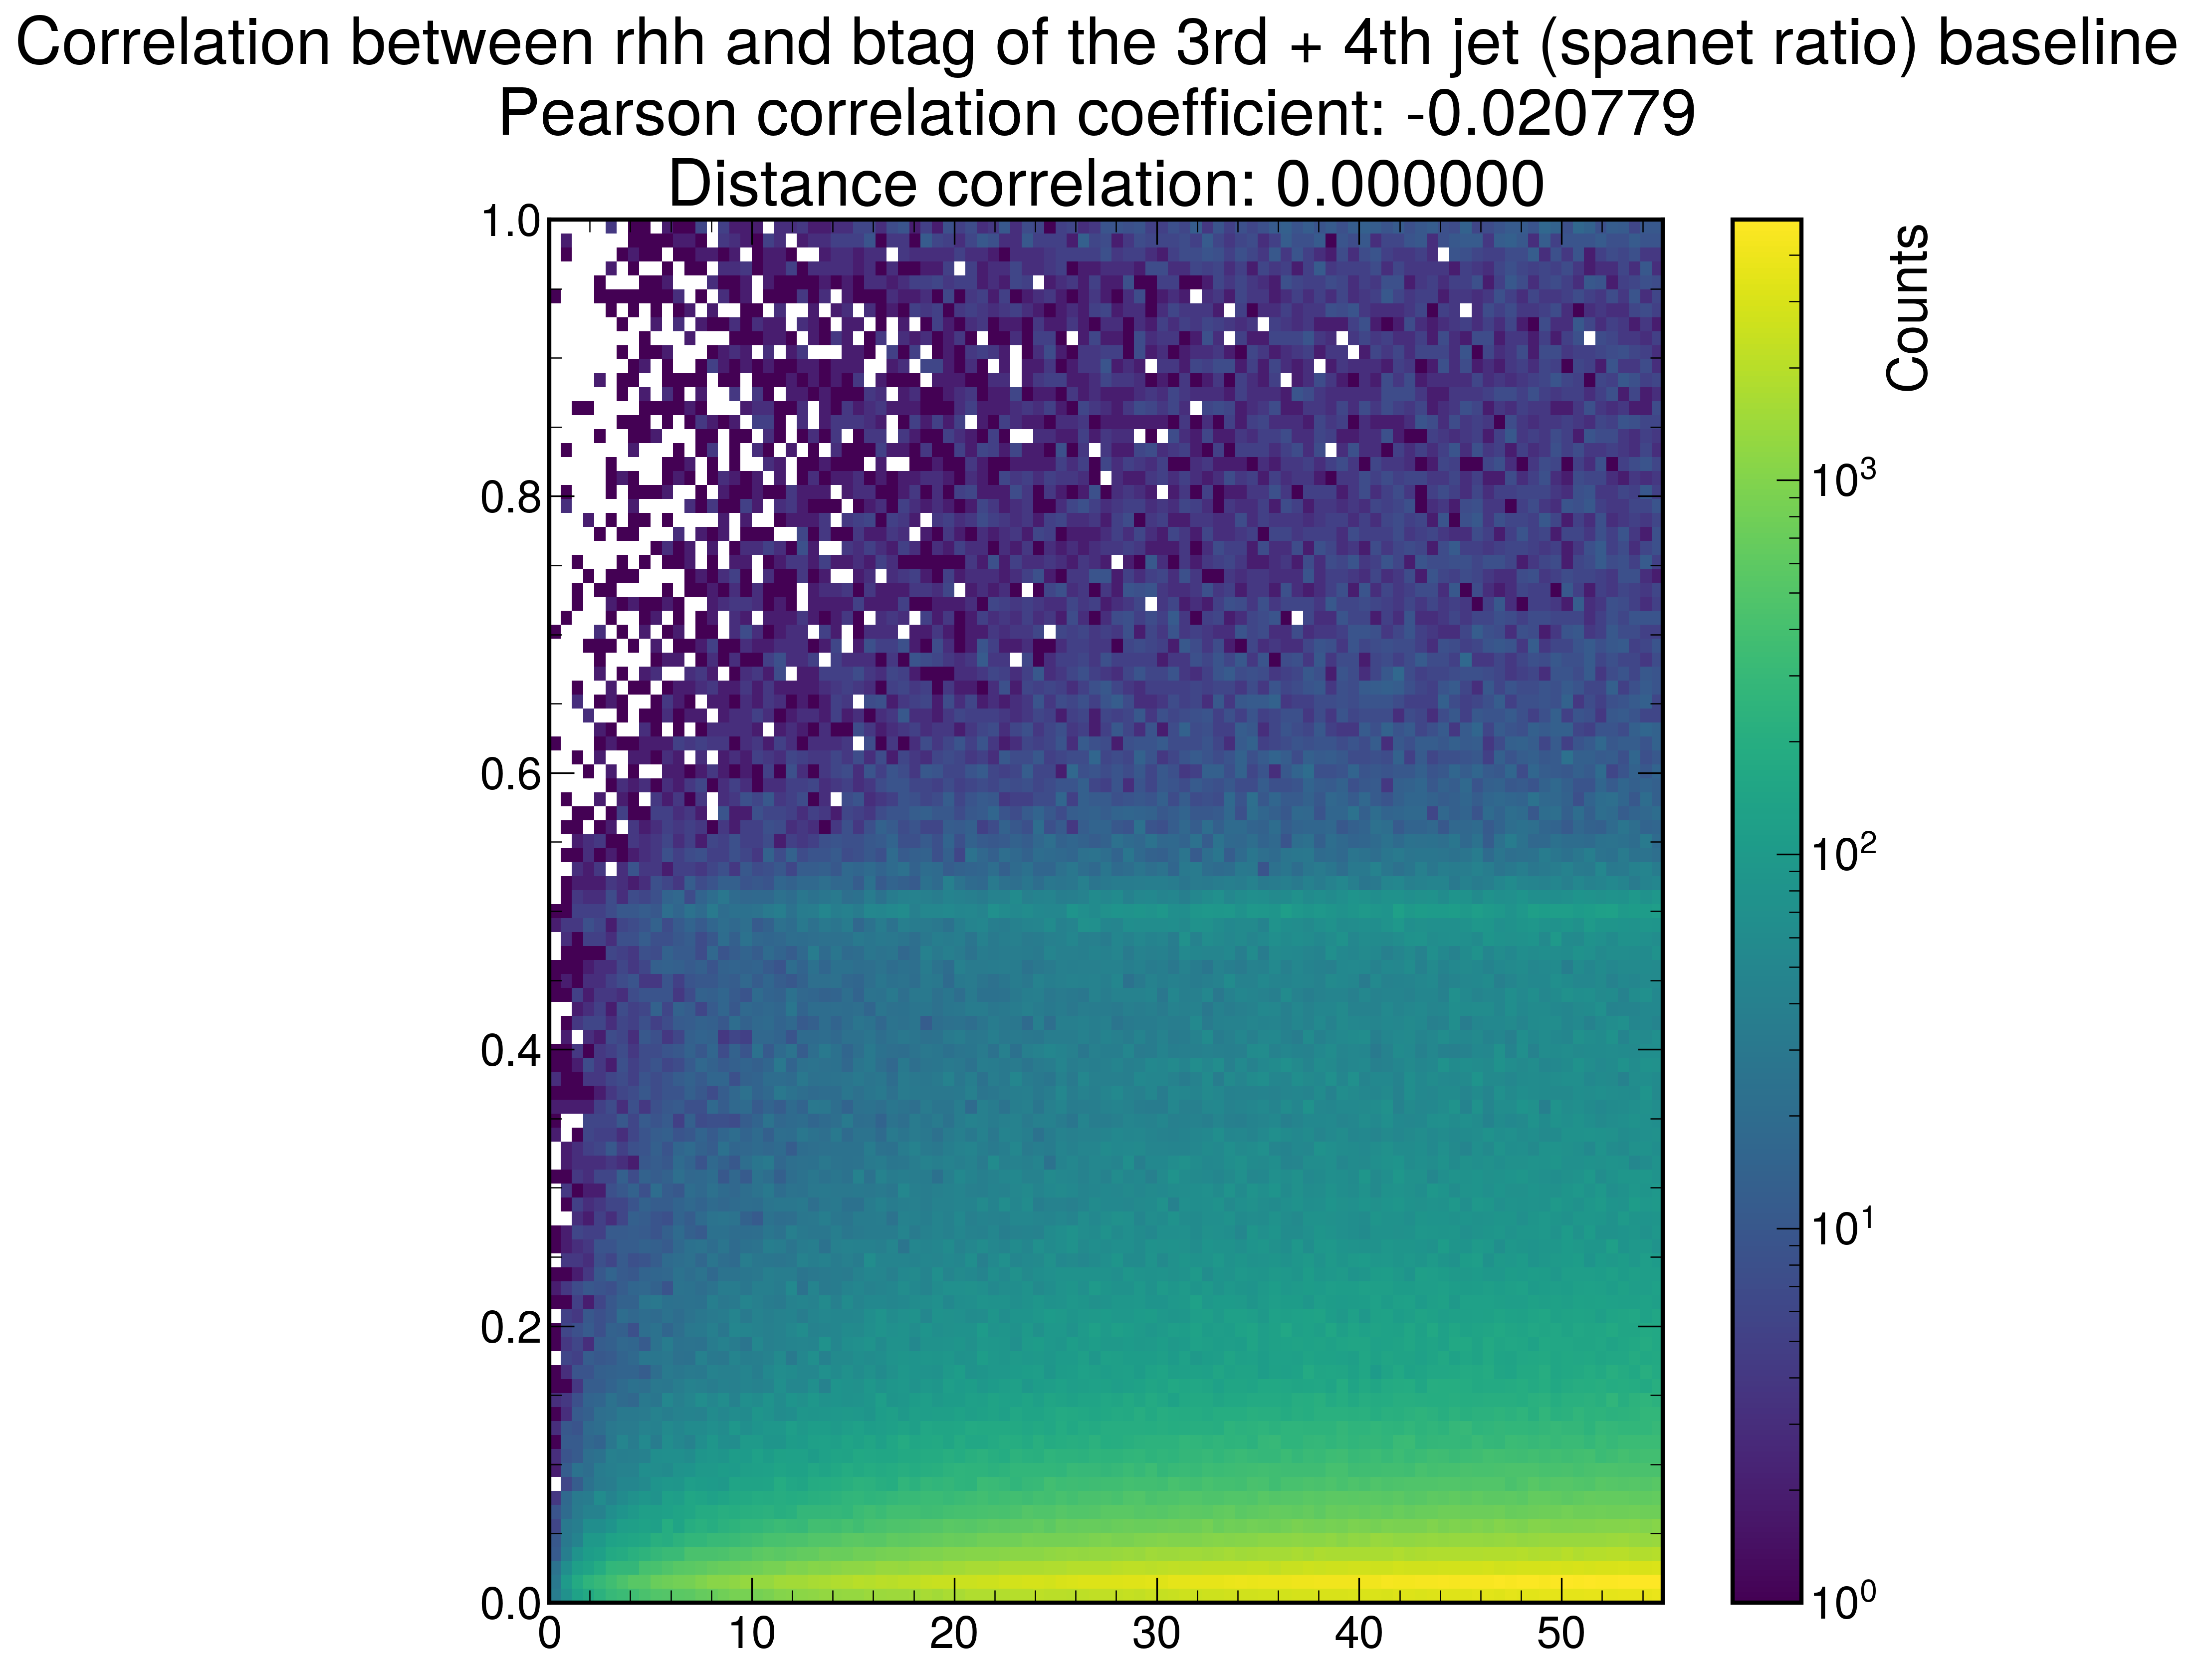

Pearson correlation coefficient (spanet ): -0.265664


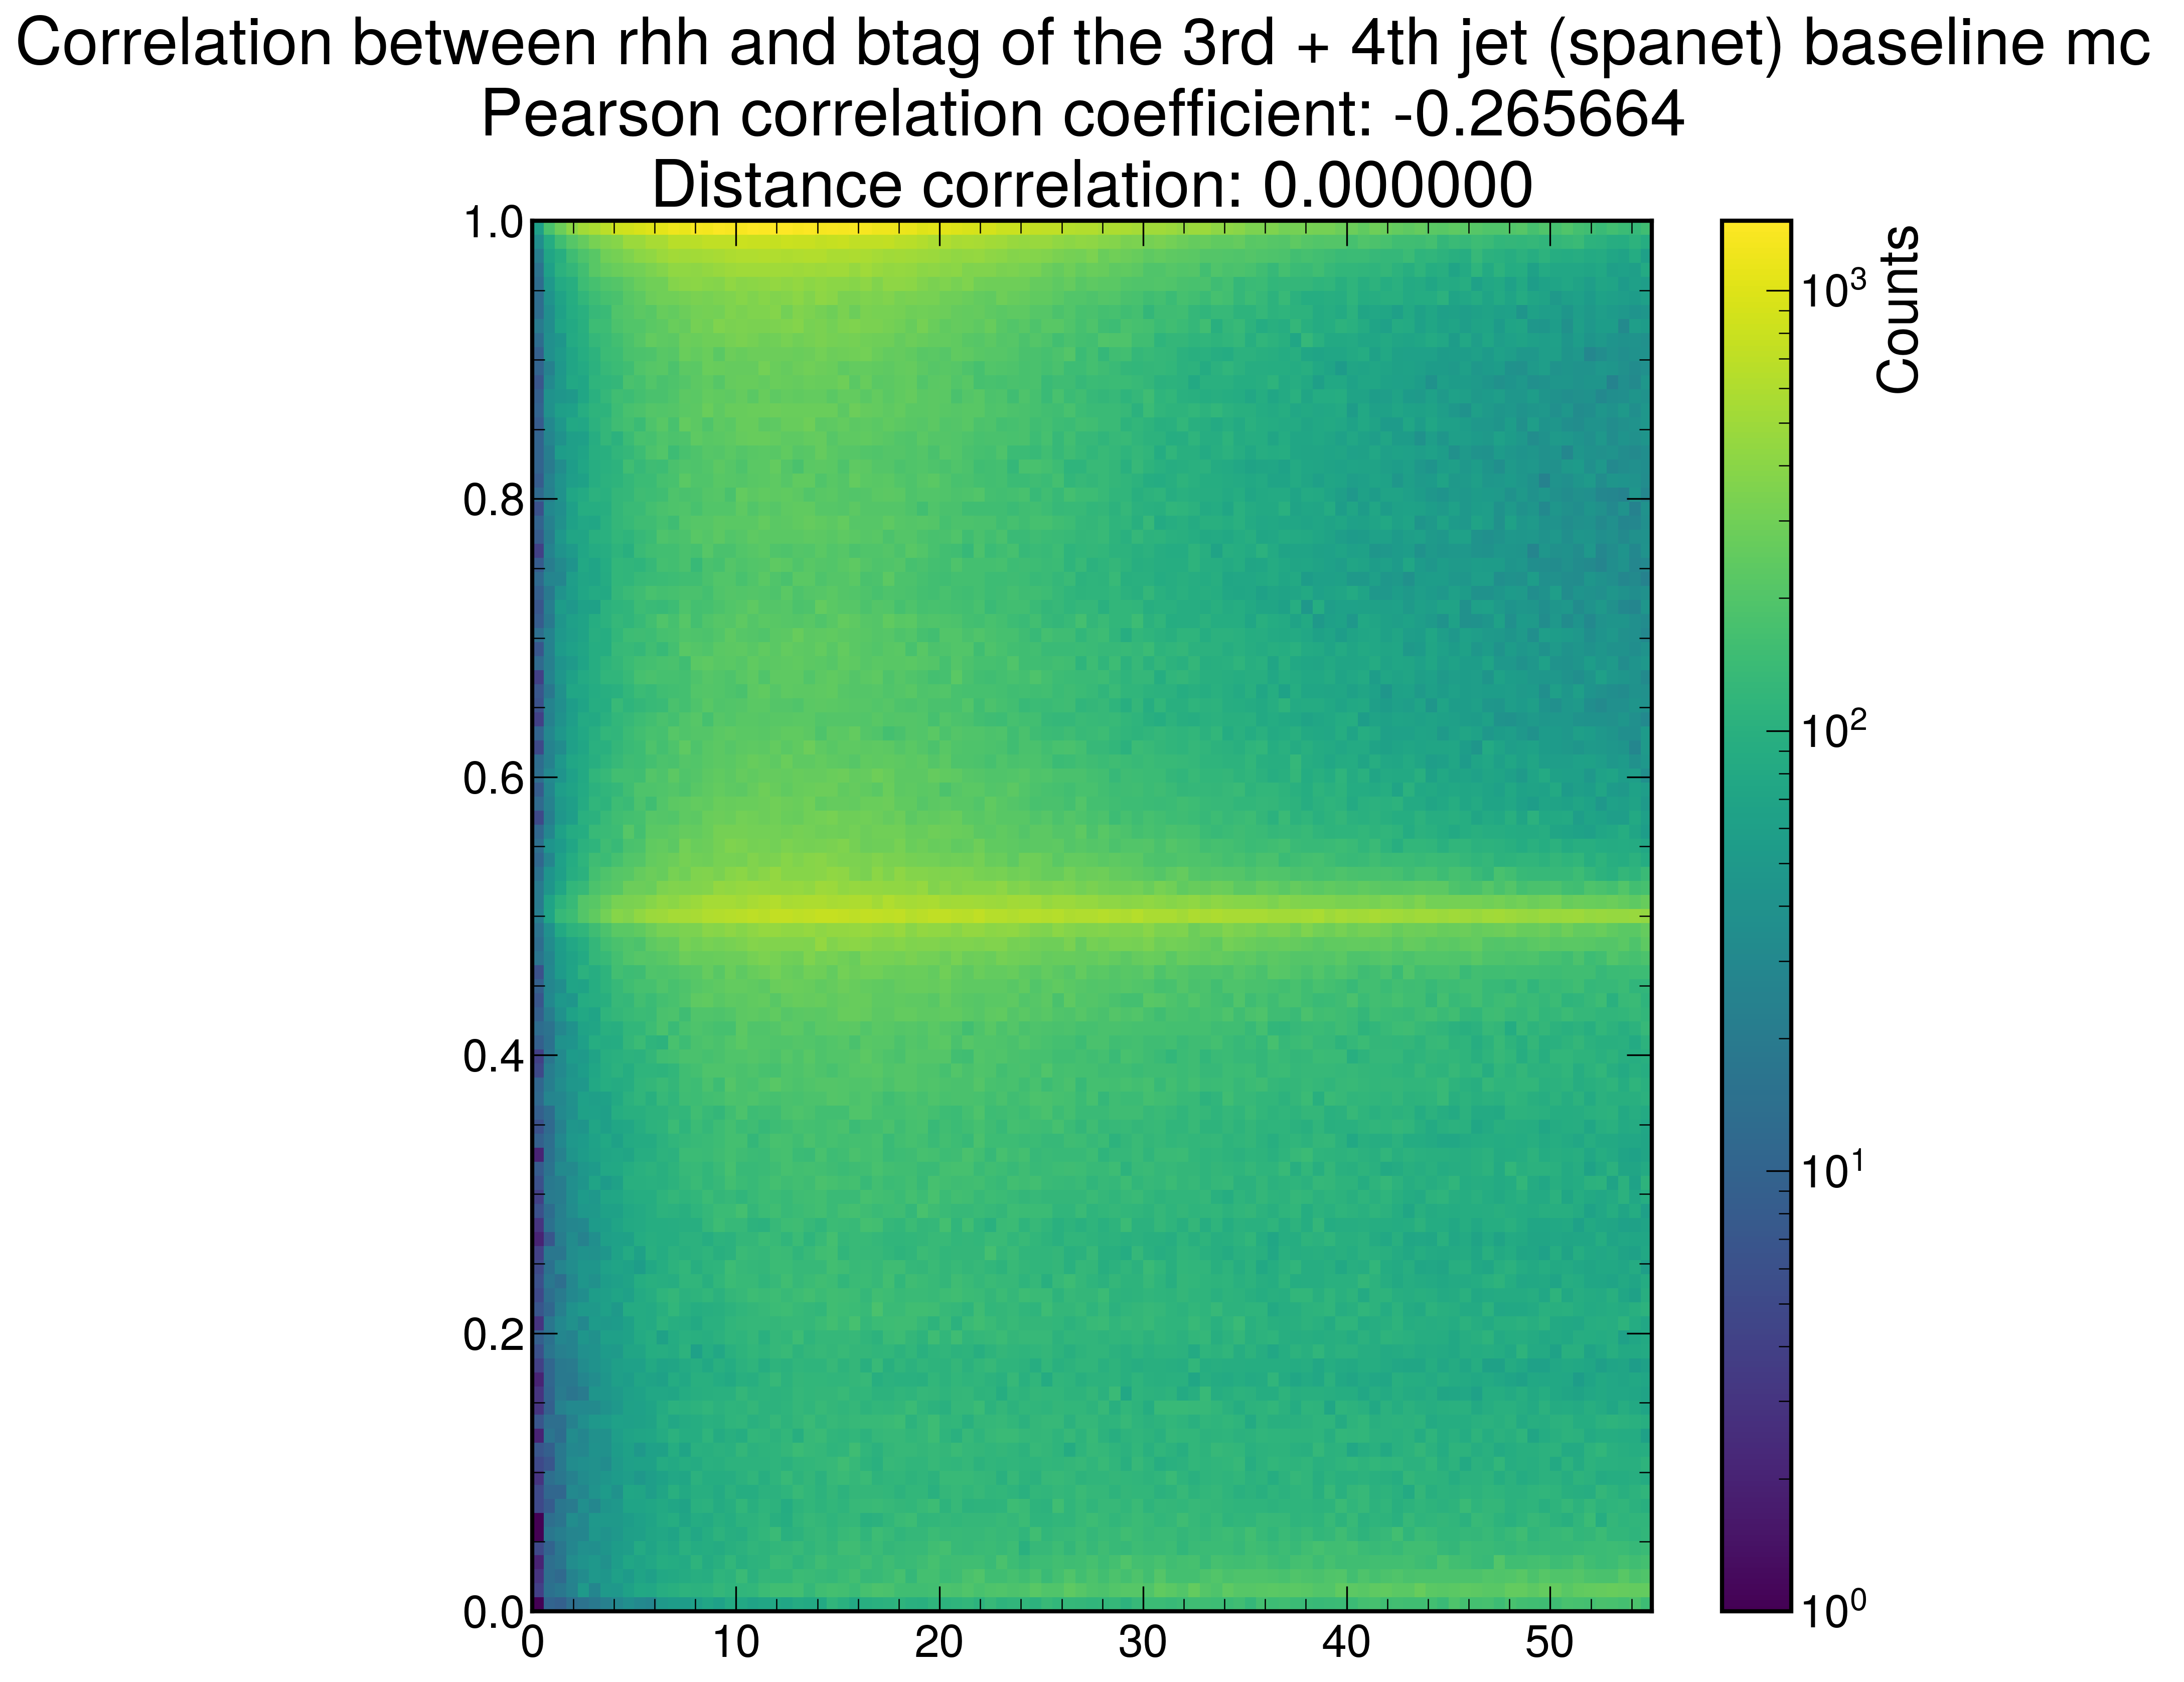

Pearson correlation coefficient (spanet ): -0.249283


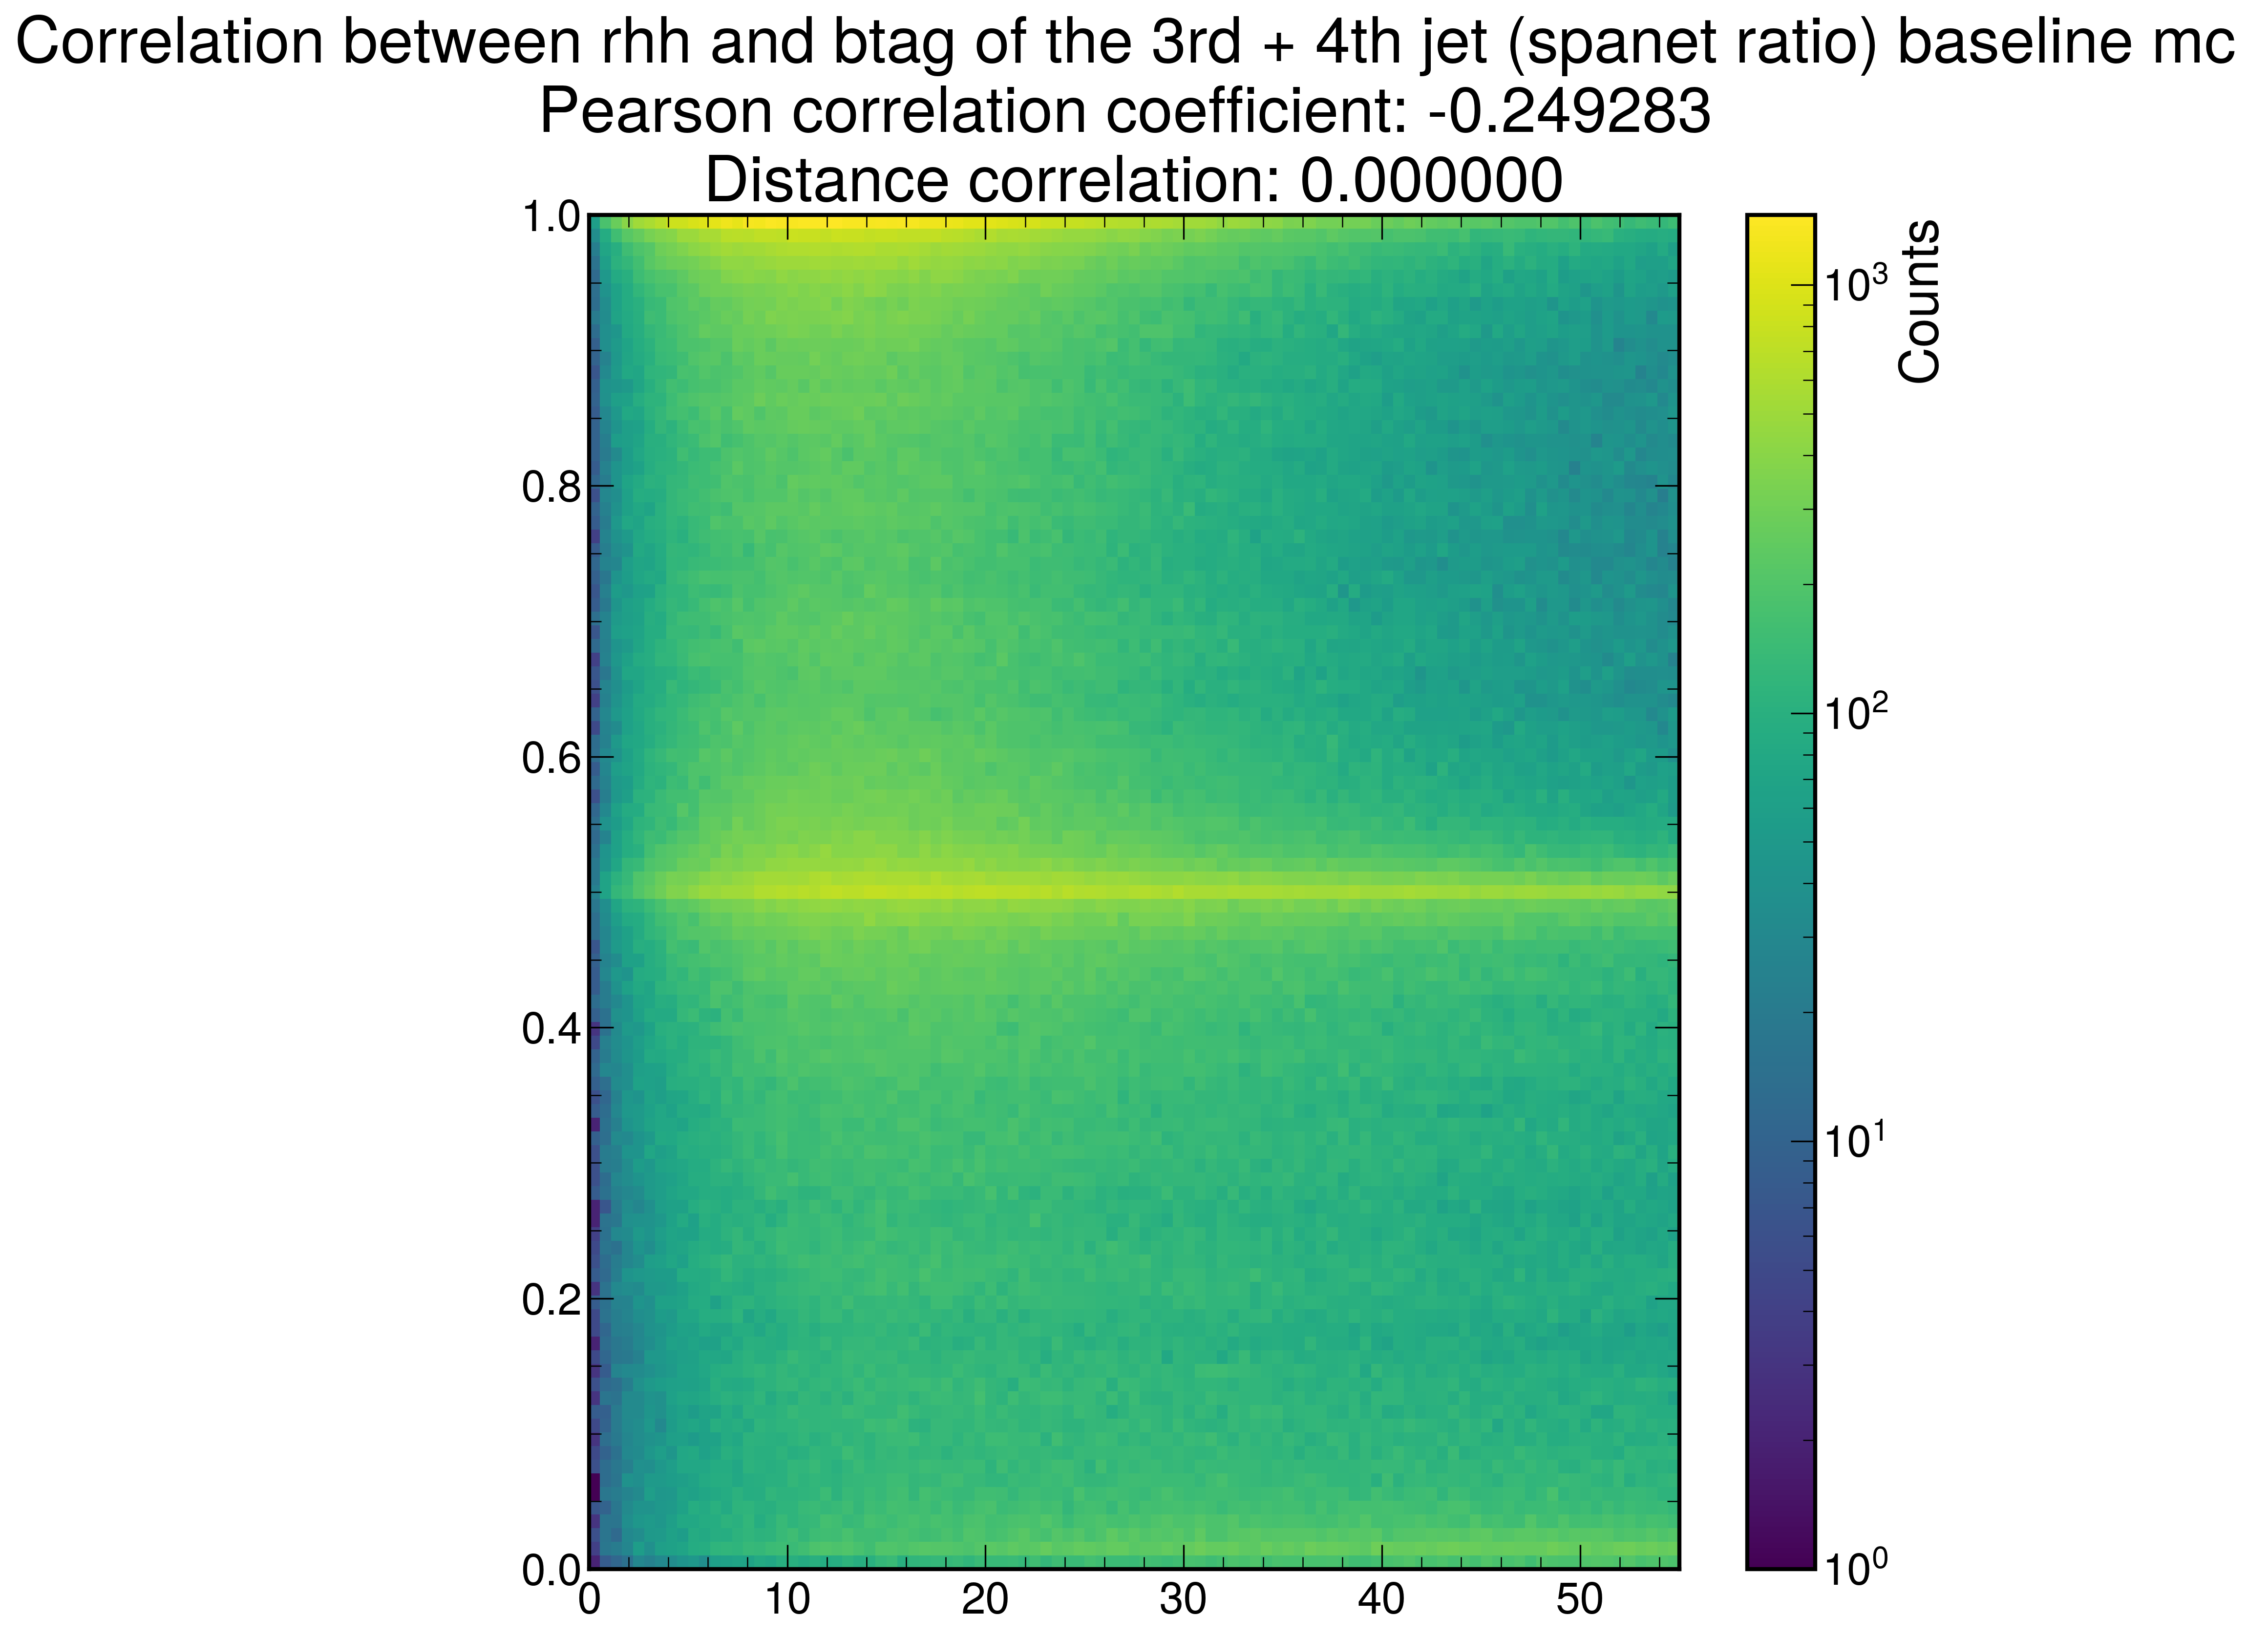

In [11]:
correlation_plot( rhh, (btag_spanet_unflattened[:,2]+btag_spanet_unflattened[:,3])/2,   "Correlation between rhh and btag of the 3rd + 4th jet (spanet) "+REGION, bins_2d)
correlation_plot(rhh_ratio,  (btag_spanet_ratio_unflattened[:,2]+btag_spanet_ratio_unflattened[:,3])/2,  "Correlation between rhh and btag of the 3rd + 4th jet (spanet ratio) "+REGION, bins_2d)
correlation_plot(rhh_mc, (btag_spanet_mc_unflattened[:,2]+btag_spanet_mc_unflattened[:,3])/2,   "Correlation between rhh and btag of the 3rd + 4th jet (spanet) "+REGION+" mc", bins_2d)
correlation_plot(rhh_ratio_mc, (btag_spanet_ratio_mc_unflattened[:,2]+btag_spanet_ratio_mc_unflattened[:,3])/2,  "Correlation between rhh and btag of the 3rd + 4th jet (spanet ratio) "+REGION+" mc", bins_2d)

# Events yield

In [12]:
def def_4b_sr(btag, rhh):
    # define the SR
    mask_4b= (btag[:,2]>0.2605) & (btag[:,3]>0.2605)
    mask_sr= rhh<30
    
    mask=mask_4b & mask_sr
    return mask

def def_pd_sr(pd, rhh, pd_cut=2):
    mask_pd= (pd>pd_cut) & (rhh<30)
    return mask_pd

def def_pd_4b(pd, btag, pd_cut=2):
    mask_pd= (pd>pd_cut) & (btag[:,2]>0.2605) & (btag[:,3]>0.2605)
    return mask_pd

In [13]:
num_bkg_4b_sr = np.sum(def_4b_sr(btag_spanet_unflattened, rhh))
num_bkg_4b_sr_ratio = np.sum(def_4b_sr(btag_spanet_ratio_unflattened, rhh_ratio))
num_4b_sr_mc = np.sum(def_4b_sr(btag_spanet_mc_unflattened, rhh_mc))
num_4b_sr_mc_ratio = np.sum(def_4b_sr(btag_spanet_ratio_mc_unflattened, rhh_ratio_mc))

print(f"Number of events in 4b SR (spanet): {num_bkg_4b_sr}, efficiency: {num_bkg_4b_sr/len(btag_spanet_unflattened)}")
print(f"Number of events in 4b SR (spanet ratio): {num_bkg_4b_sr_ratio}, efficiency: {num_bkg_4b_sr_ratio/len(btag_spanet_ratio_unflattened)}")
print(f"Number of events in 4b SR (spanet mc): {num_4b_sr_mc}, efficiency: {num_4b_sr_mc/len(btag_spanet_mc_unflattened)}")
print(f"Number of events in 4b SR (spanet ratio mc): {num_4b_sr_mc_ratio}, efficiency: {num_4b_sr_mc_ratio/len(btag_spanet_ratio_mc_unflattened)}")

print(f"S/sqrt(B) (spanet): {num_4b_sr_mc/np.sqrt(num_bkg_4b_sr)}")
print(f"S/sqrt(B) (spanet ratio): {num_4b_sr_mc_ratio/np.sqrt(num_bkg_4b_sr_ratio)}")


Number of events in 4b SR (spanet): 6326, efficiency: 0.0013582939347215872
Number of events in 4b SR (spanet ratio): 8725, efficiency: 0.0018733978154356385
Number of events in 4b SR (spanet mc): 529183, efficiency: 0.23304911760418515
Number of events in 4b SR (spanet ratio mc): 535194, efficiency: 0.2356963270684324
S/sqrt(B) (spanet): 6653.364095863665
S/sqrt(B) (spanet ratio): 5729.655601405405


In [14]:
num_bkg_pd_sr = np.sum(def_pd_sr(pd_spanet, rhh))
num_bkg_pd_sr_ratio = np.sum(def_pd_sr(pd_spanet_ratio, rhh_ratio))
num_pd_sr_mc = np.sum(def_pd_sr(pd_spanet_mc, rhh_mc))
num_pd_sr_mc_ratio = np.sum(def_pd_sr(pd_spanet_ratio_mc, rhh_ratio_mc))

print(f"Number of events in PD SR (spanet): {num_bkg_pd_sr}, efficiency: {num_bkg_pd_sr/len(pd_spanet)}")
print(f"Number of events in PD SR (spanet ratio): {num_bkg_pd_sr_ratio}, efficiency: {num_bkg_pd_sr_ratio/len(pd_spanet_ratio)}")
print(f"Number of events in PD SR (spanet mc): {num_pd_sr_mc}, efficiency: {num_pd_sr_mc/len(pd_spanet_mc)}")
print(f"Number of events in PD SR (spanet ratio mc): {num_pd_sr_mc_ratio},  efficiency: {num_pd_sr_mc_ratio/len(pd_spanet_ratio_mc)}")

print(f"S/sqrt(B) PD (spanet): {num_pd_sr_mc/np.sqrt(num_bkg_pd_sr)}")
print(f"S/sqrt(B) PD (spanet ratio): {num_pd_sr_mc_ratio/np.sqrt(num_bkg_pd_sr_ratio)}")

Number of events in PD SR (spanet): 9341, efficiency: 0.0020056629219466246
Number of events in PD SR (spanet ratio): 53658, efficiency: 0.011521235527867678
Number of events in PD SR (spanet mc): 518444, efficiency: 0.2283197244189329
Number of events in PD SR (spanet ratio mc): 471696,  efficiency: 0.20773217691691478
S/sqrt(B) PD (spanet): 5364.202530352442
S/sqrt(B) PD (spanet ratio): 2036.3149646744885


In [15]:
num_bkg_pd_4b = np.sum(def_pd_4b(pd_spanet, btag_spanet_unflattened))
num_bkg_pd_4b_ratio = np.sum(def_pd_4b(pd_spanet_ratio, btag_spanet_ratio_unflattened))
num_pd_4b_mc = np.sum(def_pd_4b(pd_spanet_mc, btag_spanet_mc_unflattened))
num_pd_4b_mc_ratio = np.sum(def_pd_4b(pd_spanet_ratio_mc, btag_spanet_ratio_mc_unflattened))

print(f"Number of events in PD 4b (spanet): {num_bkg_pd_4b}")
print(f"Number of events in PD 4b (spanet ratio): {num_bkg_pd_4b_ratio}")
print(f"Number of events in PD 4b (spanet mc): {num_pd_4b_mc}")
print(f"Number of events in PD 4b (spanet ratio mc): {num_pd_4b_mc_ratio}")

print(f"S/sqrt(B) PD 4b (spanet): {num_pd_4b_mc/np.sqrt(num_bkg_pd_4b)}")
print(f"S/sqrt(B) PD 4b (spanet ratio): {num_pd_4b_mc_ratio/np.sqrt(num_bkg_pd_4b_ratio)}")

Number of events in PD 4b (spanet): 16236
Number of events in PD 4b (spanet ratio): 9378
Number of events in PD 4b (spanet mc): 522643
Number of events in PD 4b (spanet ratio mc): 417368
S/sqrt(B) PD 4b (spanet): 4101.716282574543
S/sqrt(B) PD 4b (spanet ratio): 4309.86864481405


In [16]:
sob_max = 0.0
pd_cut_max = 0.0
num_bkg_pd_sr_max = 0.0
num_pd_sr_mc_max = 0.0

sob_ratio_max = 0.0
pd_cut_ratio_max = 0.0
num_bkg_pd_sr_ratio_max = 0.0
num_pd_sr_mc_ratio_max = 0.0

for pd_cut in np.linspace(0, 5, 20):
    
    
    num_bkg_pd_sr = np.sum(def_pd_sr(pd_spanet, rhh, pd_cut))
    num_bkg_pd_sr_ratio = np.sum(def_pd_sr(pd_spanet_ratio, rhh_ratio, pd_cut))
    num_pd_sr_mc = np.sum(def_pd_sr(pd_spanet_mc, rhh_mc, pd_cut))
    num_pd_sr_mc_ratio = np.sum(def_pd_sr(pd_spanet_ratio_mc, rhh_ratio_mc, pd_cut))

    print(f"Number of events in PD SR (spanet) with pd cut {pd_cut}: {num_bkg_pd_sr}")
    print(f"Number of events in PD SR (spanet ratio) with pd cut {pd_cut}: {num_bkg_pd_sr_ratio}")
    print(f"Number of events in PD SR (spanet mc) with pd cut {pd_cut}: {num_pd_sr_mc}")
    print(f"Number of events in PD SR (spanet ratio mc) with pd cut {pd_cut}: {num_pd_sr_mc_ratio}")

    sob = num_pd_sr_mc / np.sqrt(num_bkg_pd_sr)
    sob_ratio = num_pd_sr_mc_ratio / np.sqrt(num_bkg_pd_sr_ratio)
    print(f"S/sqrt(B) PD (spanet) with pd cut {pd_cut}: {sob}")
    print(f"S/sqrt(B) PD (spanet ratio) with pd cut {pd_cut}: {sob_ratio}")
    
    if sob > sob_max:
        sob_max = sob
        pd_cut_max = pd_cut
        num_bkg_pd_sr_max = num_bkg_pd_sr
        num_pd_sr_mc_max = num_pd_sr_mc
        
    if sob_ratio > sob_ratio_max:
        sob_ratio_max = sob_ratio
        pd_cut_ratio_max = pd_cut
        num_bkg_pd_sr_ratio_max = num_bkg_pd_sr_ratio
        num_pd_sr_mc_ratio_max = num_pd_sr_mc_ratio
        

print("\n\n ========================================================= \n")
        
print(f"Maximum S/sqrt(B) PD (spanet) with pd cut {pd_cut_max}: {sob_max}")
print("Efficiency bkg PD SR (spanet):", num_bkg_pd_sr_max/len(pd_spanet))
print("Efficiency sig PD SR (spanet):", num_pd_sr_mc_max/len(pd_spanet_mc))

print(f"Maximum S/sqrt(B) PD (spanet ratio) with pd cut {pd_cut_ratio_max}: {sob_ratio_max}")
print("Efficiency bkg PD SR (spanet ratio):", num_bkg_pd_sr_ratio_max/len(pd_spanet_ratio))
print("Efficiency sig PD SR (spanet ratio):", num_pd_sr_mc_ratio_max/len(pd_spanet_ratio_mc))

Number of events in PD SR (spanet) with pd cut 0.0: 316539
Number of events in PD SR (spanet ratio) with pd cut 0.0: 463676
Number of events in PD SR (spanet mc) with pd cut 0.0: 996964
Number of events in PD SR (spanet ratio mc) with pd cut 0.0: 1014831
S/sqrt(B) PD (spanet) with pd cut 0.0: 1772.0087553675066
S/sqrt(B) PD (spanet ratio) with pd cut 0.0: 1490.3436328344696


Number of events in PD SR (spanet) with pd cut 0.2631578947368421: 190805
Number of events in PD SR (spanet ratio) with pd cut 0.2631578947368421: 334109
Number of events in PD SR (spanet mc) with pd cut 0.2631578947368421: 889232
Number of events in PD SR (spanet ratio mc) with pd cut 0.2631578947368421: 902760
S/sqrt(B) PD (spanet) with pd cut 0.2631578947368421: 2035.7301432487689
S/sqrt(B) PD (spanet ratio) with pd cut 0.2631578947368421: 1561.8100769245207
Number of events in PD SR (spanet) with pd cut 0.5263157894736842: 101772
Number of events in PD SR (spanet ratio) with pd cut 0.5263157894736842: 244155
Number of events in PD SR (spanet mc) with pd cut 0.5263157894736842: 822589
Number of events in PD SR (spanet ratio mc) with pd cut 0.5263157894736842: 838221
S/sqrt(B) PD (spanet) with pd cut 0.5263157894736842: 2578.5095427594524
S/sqrt(B) PD (spanet ratio) with pd cut 0.5263157894736842: 1696.3900862647401
Number of events in PD SR (spanet) with pd cut 0.7894736842105263: 5

In [19]:
def def_4b(btag):
    # define the SR
    mask_4b= (btag[:,2]>0.2605) & (btag[:,3]>0.2605)
    return mask_4b
def def_3b(btag):
    # define the SR
    mask_3b= (btag[:,2]>0.2605) & (btag[:,3]<0.2605)
    return mask_3b
def def_2b(btag):
    # define the SR
    mask_2b= (btag[:,2]<0.2605) & (btag[:,3]<0.2605)
    return mask_2b

num_4b= np.sum(def_4b(btag_spanet_mc_unflattened))
num_3b= np.sum(def_3b(btag_spanet_mc_unflattened))
num_2b= np.sum(def_2b(btag_spanet_mc_unflattened))

print(f"Number of events in 4b (spanet): {num_4b}, efficiency: {num_4b/len(btag_spanet_mc_unflattened)}")
print(f"Number of events in 3b (spanet): {num_3b}, efficiency: {num_3b/len(btag_spanet_mc_unflattened)}")
print(f"Number of events in 2b (spanet): {num_2b}, efficiency: {num_2b/len(btag_spanet_mc_unflattened)}")


Number of events in 4b (spanet): 797457, efficiency: 0.3511954280036976
Number of events in 3b (spanet): 1054848, efficiency: 0.4645489284548814
Number of events in 2b (spanet): 418388, efficiency: 0.18425564354142104
